### Overview of the notebook

1. [Motivation](#chapter1)<br>
2. [Basic statistics](#chapter2)<br>
    2.1 [Cleaning and pre-processing the data](#section_2_1)<br>
    2.2 [Discussion of dataset statistics ](#section_2_2)<br>
3. [Tools, theory and analysis](#chapter3)<br>
    3.1 [Communities](#section_3_1)<br>
    3.2 [Network visualization with Gephi](#section_3_2)<br>
    3.3 [Sentiment analysis](#section_3_3)<br>
    3.4 [TF-IDF](#section_3_4)<br>
    3.5 [Word-clouds for all universes](#section_3_5)<br>
4. [Discussion](#chapter4)
5. [Reference](#chapter5)
6. [Contributions](#chapter6)

[Website](#chapter7)

# Disney Villains 

Welcome to the project about Disney's most evil characters. Below is a video from project assignment A, that explains the concept and offers a plan for the implementation. Project assignment B takes over after that.

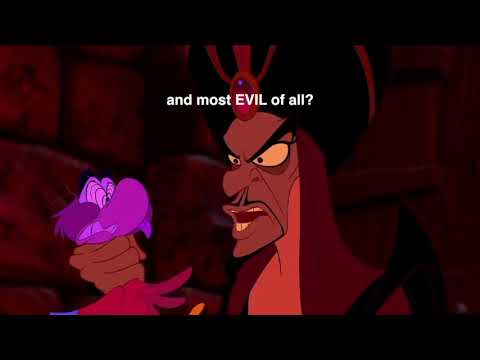

In [171]:
from IPython.display import YouTubeVideo
YouTubeVideo("9RyQ6VwNjI0", width = 800, height = 450)

# 1. Motivation <a class="anchor" id="chapter1"></a>

**The motivation:** When we think of Disney films, we feel a rush of nostalgia, as if we were watching one of those with a bowl of cereal on a Sunday morning. Therefore, it was an easy decision to take a further look into the villains of Disney, and explore the characters in a new light.

**The dataset:** The dataset was extracted from the Disney Fandom Wiki webpage, and it contains all the character villains from Dinsey. That includes characters from different universes, e.g Marvel, Pixar, Star Wars, Walt Disney and other. After having built and visualized the network, we decided to narrow the scope and maintaining at least some possibility of analysing information about the dataset, do to lack of internal connections in the whole Disney Villains dataset. We then chose to select a subset of the data, that represents one universe, Marvel. 

**The goal:** The goal of the project was to find something interesting in the dataset. 

we thought it would be interesting to to use the text-analysis tools we have learned in the course on quotes. (ATH - KLÁRA) 


### Imports

In [165]:
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import urllib.request
import json
import re
import os
import collections

from fa2 import ForceAtlas2
from matplotlib.lines import Line2D
import wordcloud
from PIL import Image
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import community
import csv

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter, OrderedDict
from scipy.stats import sem
import math

#### Helper functions to get the data

* `load_dataframe`: Reads the csv file, that contails all the villains from disney, and returns a DataFrame.
* `get_path`: Returns the path to the folder that the description txt files are placed.
* `read_data`: Reads the descriptions txt files and returns the description.
* `get_universe`: Finds what universe each villain is a part of. (LAGA)
* `merge_dataframes`: Returns a DataFrame with villains and corresponding universes.
* `get_quotes`: Finds all the quotes each villain has.
* `get_hyperlinks`: Finds all the links that connect the villains together

In [2]:
def load_dataframe(url):
    characters_df = pd.read_csv(url, sep = ';')
    return characters_df

In [3]:
# Get the path for the folder that we keep the descriptions in 
def get_path(name_of_folder):
    script_path = os.getcwd()
    folder = name_of_folder
    path = os.path.join(script_path,folder)
    return path

In [4]:
def read_data(path, char):
    with open(path + char + '.txt', 'r') as f:
        node_description = f.read()
    return node_description

In [5]:
def get_category(characters_df, pat):
    path = get_path('Villains2/')                        
    
    pattern = pat
    
    categories = []
    for char in characters_df.name_of_villains.values:
        # open the description files
        node_description = read_data(path, char)   
        
        find_categories = []
        for p in pattern:
            find_categories += re.findall(p, node_description)
            
        for cat in find_categories:
            categories.append((char, cat))

    return categories

In [6]:
def merge_and_clean_dataframe(col, category, pattern, characters_df):
    df = pd.DataFrame(set(category))
    df['name_of_villains'] = df[0]
    del df[0]
    df[col] = df[1]
    del df[1]
    df_villains_merged = pd.merge(characters_df, df, on='name_of_villains', how='left')
    return df_villains_merged

In [7]:
# Get the quotes in the DataFrame
def get_quotes(df_villains):
    path = get_path('Villains2/')
    
    quotes_pattern = '\{\{Quote\|(.*?)[\[\[(.*?)\]\]]?(?:\|.*?)\}\}'

    quotes = []
    for char in df_villains.name_of_villains.values:
        # open the description files
        node_description = read_data(path, char)
        
        find_quotes = re.findall(quotes_pattern, node_description)
            
        for q in find_quotes:
            quotes.append((char, q))

    return quotes

In [8]:
# Get the hyperlinks
def get_hyperlinks(df_villains):
    path = get_path('Villains2/')
    
    pattern = '\[\[(.*?)(?:\|.*?)?\]\]'
    links = []
    for char in df_villains.name_of_villains.values:
        # open the zelda description files
        node_description = read_data(path, char)
    
        links_square = re.findall(pattern, node_description)
   
        # For pattern including square brackets  
        for name in links_square:
            # check if character is in the char list
            if name in df_villains.name_of_villains.values:
                links.append((char, name))
            else:
                continue
    return links

### Importing dataset

In [9]:
characters_df = load_dataframe('name_of_villains_4.csv')

In [10]:
# Get the corresponding universes
universe_pattern = ['\[\[Category:(Marvel) Cinematic Universe characters\]\]',
                        '\[\[Category:(Marvel) Comics\]\]',
                        '\[\[Category:(Marvel) Comics characters\]\]',
                        '\[\[Category:(Pixar) characters\]\]',
                        '\[\[Category:(Disney) characters\]\]',
                        '\[\[Category:(Star Wars) characters\]\]',
                        '\[\[Category:(Star Wars) villains\]\]']

universe = get_category(characters_df, universe_pattern)
characters_df = merge_and_clean_dataframe('Universe', universe, universe_pattern, characters_df)

# If we have a nan value the character has no known universe
characters_df = characters_df.fillna('Unkown')
    
# In the dataframe few characters have two universes
# sort them in a way that dinsney comes first and then delete the duplicates of the first column
# this way the charcters will not belong to disney anymore
characters_df = characters_df.sort_values('Universe')
characters_df = characters_df.drop_duplicates(subset='name_of_villains', keep="last")

In [11]:
# Get the corresponging organizations - to be able to drop the organizations from our dataframe
org_pattern = ['\[\[Category:(Organizations)\]\]']
organization = get_category(characters_df, org_pattern)
characters_df = merge_and_clean_dataframe('Org', organization, org_pattern, characters_df)

In [12]:
# Only keep the characters who are not an organization
characters_df = characters_df[characters_df.Org != 'Organizations']
# Then drop organization column
characters_df = characters_df.drop('Org', 1)

In [13]:
# Add the status (deceased or alive) of each villain to the dataframe
deceased_pattern = ['\[\[Category:(Deceased).*?\]\]']
deceased = get_category(characters_df, deceased_pattern)
characters_df = merge_and_clean_dataframe('Status', deceased, deceased_pattern, characters_df)
characters_df = characters_df.fillna('Alive')

In [14]:
# Add the importance (main antaogonist or lesser villain) of each villain to the dataframe
antagonist_pattern = ['\[\[Category:(Main antagonists)\]\]']
antagonist = get_category(characters_df, antagonist_pattern)
characters_df = merge_and_clean_dataframe('Importance', antagonist, antagonist_pattern, characters_df)
characters_df = characters_df.fillna('Lesser villain')

In [15]:
characters_df

name_of_villains Universe    Status        Importance
0                 Rippen   Disney     Alive  Main antagonists
1         Doug Slackwell   Disney     Alive    Lesser villain
2             Amos Slade   Disney     Alive  Main antagonists
3                    Kat   Disney     Alive    Lesser villain
4             John Slade   Disney     Alive  Main antagonists
...                  ...      ...       ...               ...
2743             Georgie   Unkown  Deceased    Lesser villain
2744             Trantor   Unkown  Deceased  Main antagonists
2745     Olivier Trajean   Unkown     Alive  Main antagonists
2746        Texie Garcia   Unkown     Alive    Lesser villain
2747  Greylock the Grand   Unkown     Alive    Lesser villain

[2748 rows x 4 columns]

In [16]:
links = get_hyperlinks(characters_df)

# 2. Basic statistics <a class="anchor" id="chapter2"></a>

Let's examine some basic statistic before we go further into preprocessing the data. This includes:

* Number of disney villains that are in the dataset
* Number of directed links
* Number of different universes that are extracted from the text analysis

In [17]:
print('There are', len(characters_df), 'Disney villains,', len(links), 'directed links and', 
      len(set(characters_df['Universe'])), 'different universes in our dataset')

There are 2748 Disney villains, 9945 directed links and 5 different universes in our dataset


In [202]:
# plot here, percentage of dead main anatagonists

## 2.1 Cleaning and pre-processing the data <a class="anchor" id="section_2_1"></a>

We are interested in visualizing the network, as well as performing analysis on the data further on in this notebook. Therefore we must do a lot of cleaning on the data. 



The text for all the villains included a lot of different content, for example, words, numbers and special charactes. Therefore we had to make a few patterns to remove the elements we did not want our clean text to consist of. The functionality of the patterns is as follows:

* Remove external links - that link to another part of the fandom website
* Remove images in a gallery
* Remove infobox - that includes backround and character information
* Remove everything inside a curly brackets - that includes links and citations
* Remove titiles and chapter breaks
* Remove titles of paragraphs
* Remove the categories that the character is a part of (we used it in the begining to get the universes, so this will not be needed anymore)
* Remove small numbers - that is citations
* Remove images in the text
* Remove new lines
* Remove special characters
* Remove specific recurrent words
* Replace multiple spaces with one
* Remove words that are less then 2 on lenght

word cloud = hvaða orð i universes eru áhguaverð- hvaða orð hafa áhrif
sentimental = skoða hvern characters
TF-IDF = clena text fyrir alla characterana

In [18]:
for name in list(characters_df['name_of_villains'].values):
    path = get_path('Villains2/')
    node_description = read_data(path, name)     
    
    node_description = re.sub(r"External links==(.*?)\\n\[\[Category", " ", node_description) # remove external links (links to another part of the fandom website)
    node_description = re.sub(r"Gallery==(.*?)\<\/gallery\>\\n\\n", " ", node_description) # remove gallery (the part with the photos in gallery)
    node_description = re.sub(r"(\{\{.*?)'''", " ", node_description)    # remove infobox (has backround and charactersimformation)   
    node_description = re.sub(r"\{\{(.*?)\}\}", " ", node_description)  # remove curly brackets (links and citations)
    node_description = re.sub(r"==(==.*?==)==", " ", node_description)   # remove titles and chapter breaks
    node_description = re.sub(r"(==.*?==)", " ", node_description)       # remove the name of the paragraphs 
    node_description = re.sub(r"(\[\[Category:.*?\]\])", " ", node_description)   #   remove categories links that we used in the beginng but dont need anymore
    node_description = re.sub(r"(\<\/?ref.*?>)", " ", node_description)      # remove references citations (small numbers)
    node_description = re.sub(r"(\[\[File.*?\|thumb\|.*?\]\])", " ", node_description) #  remove images in text 
    node_description = re.sub(r"(\\n)", " ", node_description)         # remove new line
    node_description = re.sub(r"\W+", " ", node_description)    # remove special characters (keep words and numbers)
    node_description = re.sub(r"\s(one|two|later)\s", " ", node_description)   # remove specific recurrent words, that appear too often
    node_description = re.sub(r"\\s+", " ", node_description)       # replace multiple spaces with one
    node_description = ' '.join(word for word in node_description.split() if len(word)>2)
    
    path = get_path('Clean_text/')
    with open(path + name + '.txt', 'w') as file:
        json.dump(node_description, file)

#### Helper functions for the cleaning

* `get_composite_names`: Returns both composite and normal to be able to remove the corposite names before we tokenize the text (because the tokenizer could ruin the composite names)
* `get_cleaned_dict`: Remove names from cleaned text, tokenize the text, put everything in lower case, reomve stop words, remove any numbers and finally lemmatize the text.

In [19]:
# convert the file names
def get_composite_names(characters_df):
    normal_name = []
    comp_name = []
    list_of_names = characters_df['name_of_villains'].tolist()
    for name in list_of_names:
        if ' ' in name:
            comp_name.append(name)
        else:
            normal_name.append(name)
    return comp_name, normal_name

In [20]:
def get_cleaned_dict(characters_df, column, list_of_column):
    tokenized_dict= {}
    for item in list_of_column:
        final_list = []
        df = characters_df[characters_df[column] == item] # svo ég þurfi ekki að loopa í gegnum allt, heldur bara þegar name samsvarar raceinu sem ég er staðsett í
        for char in df['name_of_villains']:
        
            path = get_path('Clean_text/')
            content = read_data(path, char)  
    
            # remove composite names -> before we tonkenize
            comp_name, normal_name = get_composite_names(characters_df)
            for name in comp_name:
                content = content.replace(name, "")
        
            tk = RegexpTokenizer(r'\w+') # use this tokenizer to be able to remove punktuation in an easy way
            token_content = tk.tokenize(content)
    
            #  remove normal names
            words = [word for word in token_content if word not in normal_name]

            # put everything in lower case
            words = [word.lower() for word in words]
        
            # remove stop words
            words = [word for word in words if word not in stopwords.words('english')]
        
            # remove tokens containing numbers
            words = [x for x in words if not any(c.isdigit() for c in x)]
        
    
            wnl = WordNetLemmatizer()
            words = [wnl.lemmatize(word) for word in words]
        
            final_list.extend(words) # not to override
        tokenized_dict[item] = final_list
    return tokenized_dict

In [21]:
# Create a list of universes
universe_list = list(set(characters_df['Universe']))
list_of_names = characters_df['name_of_villains'].tolist()

In [22]:
dict_of_universes = get_cleaned_dict(characters_df, 'Universe', universe_list);

## 2.2 Discussion of dataset statistics <a class="anchor" id="section_2_2"></a>

To get a sense of the data that we are working with, let's look at the entier network and its features. To visualize this, we decided to create a random network with the same amount of nodes and edges as the whole villains network. This was done to compare the degree distribution and check if our intuitions about what we should observe is correct.

In [23]:
# Make a network
villians_network = nx.DiGraph()

# Add egdes
villians_network.add_edges_from(links)

# Discard isolated nodes
villians_network.remove_nodes_from(list(nx.isolates(villians_network)))

In [24]:
# Extract the giant connected component
gcc = villians_network.subgraph(max(nx.weakly_connected_components(villians_network), key=len))

In [25]:
# Lenght of nodes and edges, and the value of p (probability for edge creation)
gcc_nodes = len(gcc.nodes)
gcc_edges = len(gcc.edges)
p = gcc_edges/(gcc_nodes*(gcc_nodes-1))

In [26]:
random_network = nx.fast_gnp_random_graph(gcc_nodes, p, directed=True)

In [27]:
# Find the in and out degree for the villains network
degree_in = list(dict(gcc.in_degree()).values())
degree_out = list(dict(gcc.out_degree()).values())
# Find the degree for the random network
degree_random = list(dict(random_network.degree()).values())

In [28]:
# Find the count of the degrees
degree_count_in = pd.Series(degree_in).value_counts()
degree_count_out = pd.Series(degree_out).value_counts()
degree_count_random = pd.Series(degree_random).value_counts()

In [29]:
# Find the top 5 in-degree
top_indegree = sorted(dict(gcc.in_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 in-degree of the Villains network:\n')
for i in list(top_indegree[:5]):
    print(i[0],'-->',i[1])
print('\n')
# Find the top 5 out-degree
top_outdegree = sorted(dict(gcc.out_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 out-degree of the Villains network:\n')
for i in list(top_outdegree[:5]):
    print(i[0],'-->',i[1])

Top 5 in-degree of the Villains network:

Captain Hook --> 80
Pete --> 73
Maleficent --> 70
Hades --> 63
Jafar --> 60


Top 5 out-degree of the Villains network:

The Overtakers --> 40
Captain Hook --> 33
Cruella De Vil --> 31
Maleficent --> 30
The Evil Queen --> 30


Above we can see the villains that have the highest in- and out-degree. We notice that the highest in-degree is not significant high, compared to the number of nodes in the network.

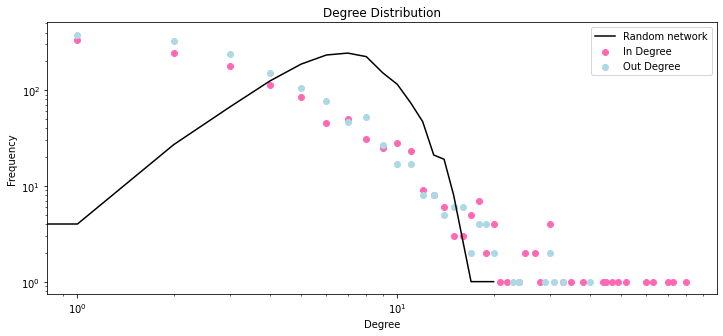

In [30]:
# Plot the in degree, out degree and random network degree
plt.figure(figsize=(12,5))
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
ind = plt.scatter(degree_count_in.index, degree_count_in, color='HotPink')
outd = plt.scatter(degree_count_out.index, degree_count_out, color='lightblue')
rand_argsort = np.argsort(degree_count_random.index)
totd = plt.plot(degree_count_random.index[rand_argsort], degree_count_random.iloc[rand_argsort], color='black')
plt.legend(['Random network','In Degree', 'Out Degree',])
plt.xscale('log')
plt.yscale('log')
plt.show()

From the figure, we see that the in-degree distribution looks a lot like a scale free network, when seen on the log-log plot. Although it is very different from the random network, we also see a slight curve in the distribution so it doesn't perfectly follow a power-law distribution, and therefore we can't declare it as a scale free network. When we look at the out-degree, we see that it is very similar to the in-degree distribution. This is reasonable since the connections in the whole villains network are very sparse, and the charcters have similar amount of in- and out-degree, which encourages us to look further into a specific universe inside the whole villains network. 

Let’s visualize the villains network and see how the connections in between the universes are. 

In [31]:
# Get node positions based on the Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          edgeWeightInfluence=0.5,
                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # Tuning
                          scalingRatio=5.0,
                          strongGravityMode=True,
                          gravity=1,
                          # Log
                          verbose=False)

In [32]:
gcc_undirected = gcc.to_undirected()

In [33]:
degrees = [val for node,val in gcc_undirected.degree()]

# Scale node size according to degree
node_size = [i * 1.6 for i in degrees]

In [34]:
# Get color nodes according to the universe
marvel_df = characters_df.loc[(characters_df['Universe'] == 'Marvel')]
star_wars_df = characters_df.loc[(characters_df['Universe'] == 'Star Wars')]
pixar_df = characters_df.loc[(characters_df['Universe'] == 'Pixar')]
disney_df = characters_df.loc[(characters_df['Universe'] == 'Disney')]
unkown_df = characters_df.loc[(characters_df['Universe'] == 'Unkown')]

color_roles = []
for node in gcc_undirected.nodes():
    if node in marvel_df.name_of_villains.values:
        color_roles.append('#00FF00')
    elif node in star_wars_df.name_of_villains.values:
        color_roles.append('#FF0000')
    elif node in pixar_df.name_of_villains.values:
        color_roles.append('#000000')
    elif node in disney_df.name_of_villains.values:
        color_roles.append('#04D8B2')
    elif node in unkown_df.name_of_villains.values:
        color_roles.append('#FF7F50')

In [35]:
edge_colors = []
for u, v in gcc_undirected.edges():
    edge_colors.append("#C0C0C0")

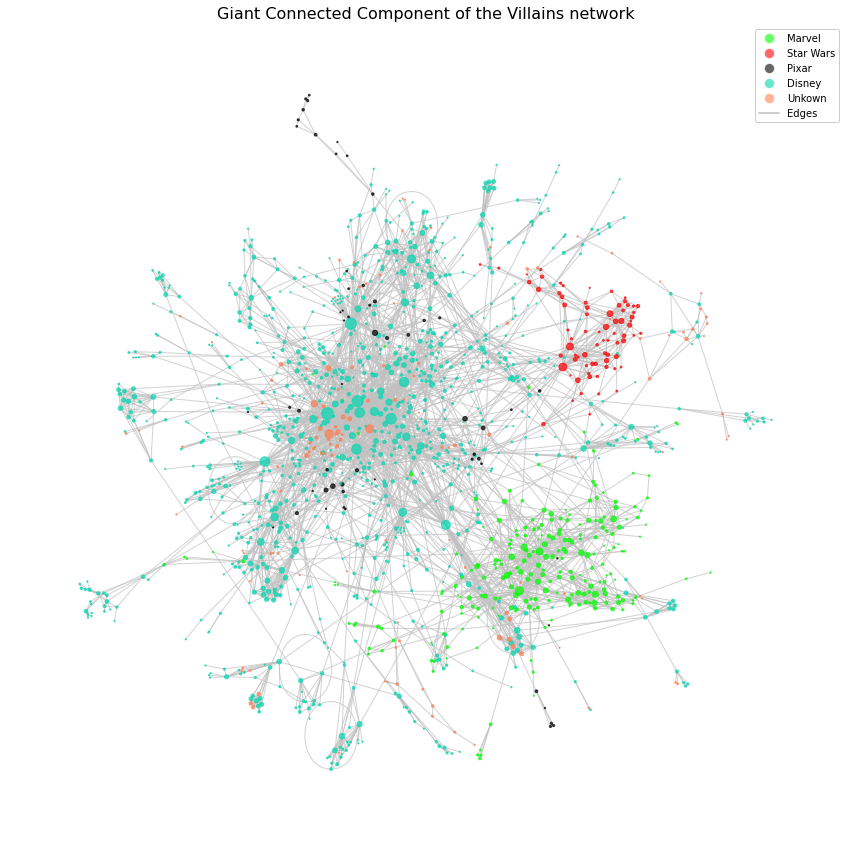

In [36]:
f = plt.figure(figsize=(15,15))
ax = plt.gca()

# Create a legend for the different colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Marvel',
                          markerfacecolor="#00FF00", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Star Wars',
                          markerfacecolor="#FF0000", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Pixar',
                          markerfacecolor="#000000", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Disney',
                          markerfacecolor="#04D8B2", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Unkown',
                          markerfacecolor="#FF7F50", markersize=10, alpha=0.6),
                   Line2D([0], [0], color="#C0C0C0", label='Edges')]

positions = forceatlas2.forceatlas2_networkx_layout(gcc_undirected, pos=None, iterations=50)
nodes = nx.draw_networkx_nodes(gcc_undirected, positions, node_size=node_size, node_color=color_roles, alpha=0.7)
edges = nx.draw_networkx_edges(gcc_undirected, positions, edge_color=edge_colors,alpha=0.7)

plt.axis('off')
plt.title("Giant Connected Component of the Villains network", fontsize=16)

plt.legend(handles=legend_elements, facecolor='white', framealpha=1)

plt.show()

The figure above shows the whole Villains network, with different colors for all the five universes and we must say it looks a little crazy. On the figure we see that there are some groups that are better connected than others. Those groups represent the different universes. The Marvel universe is displayed with green color, Star Wars with red color, Pixar with gray color, Walt diseny with blue color and the villains who are not a part of a specific universe, are represented with pink color (Unknown).

From this, we want to examine if there is any strong connection between different universes. We decided to compute the 10 highest connections among different universes. The results are displayed in the DataFrame below.

In [37]:
# create dictionary from df_villains dataframe
node_attr = characters_df.set_index('name_of_villains').to_dict('index')
# add attributes to the nodes of gcc_undirected
nx.set_node_attributes(gcc_undirected, node_attr)

In [38]:
# We don't take into account characters thet are not assigned in any of our four main universes
list_multiverse = []
for u, v in gcc_undirected.edges():
    role_u = gcc_undirected.nodes[u]['Universe']
    role_v = gcc_undirected.nodes[v]['Universe']
    if role_u == 'Unkown':
        continue
    elif role_v == 'Unkown':
        continue
    else:
        if role_u != role_v:
            list_multiverse.append((u,v))
        else:
            continue

In [39]:
out = [item for t in list_multiverse for item in t]
x = collections.Counter(out)
top_connection_between_universes = pd.DataFrame(x.most_common(10), columns=['Name', 'connections'])

In [40]:
top_connection_between_universes

Name  connections
0           Darth Vader           11
1         Randall Boggs            7
2  Lots-o'-Huggin' Bear            5
3             Palpatine            5
4   Heinz Doofenshmirtz            4
5                 Venom            4
6          Captain Hook            4
7               Dracula            4
8          Emperor Zurg            3
9       Ercole Visconti            3

When looking at the DataFrame, we see that Darth Vader is the villain that has the highest number of connections to other unviserses. When exploring this further, we saw that these connections were not because Darth Vader appears or recognizes characters from other disney moveies. Rather because that there are some characters in other movies that are inspired by him and his features. 

These results motivated us to narrow down the subject, and take a further look into one cluster or universe in the whole giant component disney villain network. When looking at the figure of the network above, we can see that the green nodes or the nodes that represent Marvel universe, from a large separated group. From this we decided to take a subset of the whole network, and look even further into the Marvel universe.

### Marvel Network

In [41]:
# Make a network
marvel_network = nx.DiGraph()

# Add egdes
marvel_links = get_hyperlinks(marvel_df)
marvel_network.add_edges_from(marvel_links)

# Discard isolated nodes
marvel_network.remove_nodes_from(list(nx.isolates(marvel_network)))

In [42]:
# Extract the giant connected component
gcc_marvel = marvel_network.subgraph(max(nx.weakly_connected_components(marvel_network), key=len))

In [43]:
gcc_undirected_marvel = gcc_marvel.to_undirected()

In [44]:
# Find the top 5 in-degree
top_indegree_marvel = sorted(dict(gcc_marvel.in_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 in-degree of the Villains network:\n')
for i in list(top_indegree_marvel[:5]):
    print(i[0],'-->',i[1])
print('\n')
# Find the top 5 out-degree
top_outdegree_marvel = sorted(dict(gcc_marvel.out_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 out-degree of the Villains network:\n')
for i in list(top_outdegree_marvel[:5]):
    print(i[0],'-->',i[1])

Top 5 in-degree of the Villains network:

Loki Laufeyson --> 32
Thanos --> 30
Grant Ward --> 21
Baron Zemo --> 20
Kree --> 18


Top 5 out-degree of the Villains network:

Loki Laufeyson --> 23
Grant Ward --> 20
Thanos --> 18
Gideon Malick --> 16
Amora the Enchantress --> 15


Above is the top 5 highest in- and out-degree for the Marvel network.

In [162]:
def get_top_centrality(G, func, top_n=10):
    degree_cent = func(G)
    degree_cent_ordered = OrderedDict(sorted(degree_cent.items(), 
                                             reverse=True, 
                                             key=lambda x: x[1])[:top_n])
    return degree_cent_ordered

In [163]:
bc_cent = get_top_centrality(gcc_marvel, nx.betweenness_centrality)

In [203]:
bc_cent

OrderedDict([('Thanos', 0.2665475810469528),
             ('Loki Laufeyson', 0.15490414284811332),
             ('Ultron', 0.1263867532428798),
             ('Glenn Talbot', 0.10696105353955734),
             ('Doctor Octopus', 0.09200180534548125),
             ('Grant Ward', 0.0785529986643415),
             ('Kree', 0.06756193170792019),
             ('Baron Zemo', 0.06487881548780862),
             ('Red Skull', 0.06368685213436996),
             ('Holden Radcliffe', 0.056260279658739705)])

Betweeness centrality is a measure based on shortest path. All the nodes in our network are connected, so for every couple of them there is a shortest path. The value of betweenes centrality for a node n is measured the number of shortest paths that pass through n (not counting the sortest paths initiated or ended in n) and then modded by dividing with the total number of shortest paths in the network. Generally, the higher the number means the the node has more influence in the network, since more information passes through it. <br> In our Network we see that Thanos has by far the greatest influence in the Marvel universe, not only because he is the main antagonist in the most recent Marvel movies, but mostly because of his regular appearances in comics since 1973. This is represented by the fact that he is a part of 25% of the total shortest paths. In the next place is Loki, who has multiple on-screen appearances and third is Ultron who, as an enemy of Avengers, cooperates has joinned forces with many other villains.

# 3. Tools, theory and analysis <a class="anchor" id="chapter3"></a>

The following step-by-step approach was used to analyse each subsection of this chapter: 
* Explain what we're interested in
* Explain the tool
* Apply the tool
* Discuss the outcome

## 3.1 Communities <a class="anchor" id="section_3_1"></a>

### What we're interested in

We want to detect and partition the network into communities using a community detection algorithm. We then want to add the detected communities as node attributes to the network and save it as a csv file so that we can visualize the network in Gephi, which is a vialuzation tool that we will use later in this notebook. The results will then be put on the website. 

### Explain the tool

To gain more insights into the villan network, community detection is applied using the Louvain algorithm. This algorithm is used to extract communities from large networks. the Louvain algorithm uses a greedy optimization approach that optimizes modularity, resulting in the best feasible grouping of nodes in a network. Modularity measures the strenght of division of a network into communities. The value of modularity is in the range [-1/2, 1], and defined as: 

$
{\displaystyle Q={\frac {1}{2m}}\sum \limits _{ij}{\bigg [}A_{ij}-{\frac {k_{i}k_{j}}{2m}}{\bigg ]}\delta (c_{i},c_{j}),}
$

where:

* $A_{ij}$ represents the edge weight between nodes ${\displaystyle i}$ and ${\displaystyle j}$

* $k_{i}$ and $k_j$ are the sum of the weights of the edges attached to nodes ${\displaystyle i}$ and ${\displaystyle j}$, respectively

* $m$ is the sum of all of the edge weights in the graph

* $c_{i}$ and ${\displaystyle c_{j}}$ are the communities of the nodes

* $\delta$  is Kronecker delta function (${\displaystyle \delta (x,y)=1}$ if ${\displaystyle x=y}, {\displaystyle 0}$ otherwise).

Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. [Ref: Modularity](https://en.wikipedia.org/wiki/Modularity_(networks))

The method used, computes the partition of the graph nodes which maximises the modularity using the Louvain heuristices. The algorithm initially creates random communities and then calculates their modularity. Then it optimizes the outcome by swaping nodes in different communities until there is no significant improvement of modularity. Then, all the nodes belonging to a community are merged into one giant node. The links that connect the giant nodes are the sum of the initial links. Then, the modularity is optimized again by clustering communities of communities and this is how the final communities are given. [Ref: Louvain_method](https://en.wikipedia.org/wiki/Louvain_method)

### Apply the tool

#### Helper functions to get communities

* `communities`: Returns a list of lists with the name of every villain that are in each community.
* `get_list_with_size_of_communities`: Returns the community and the size of it.
* `get_top_communities`: Returns the top three connected villains for each community.

In [45]:
def communities(graph, partition):
    partition = community.best_partition(graph)
    d = collections.defaultdict(list)
    # the community.best_partition function maps nodes to a community number, below we map 
    for com in set(partition.values()):
        for nodes in partition.keys():
            if partition[nodes] == com:
                d[com].append(nodes)
    return list(d.values())

In [46]:
def get_list_with_size_of_communities(marvel_communities):
    list_communities = []
    for com in marvel_communities:
        list_communities.append((len(com), com))
    return list_communities

In [47]:
def get_top_communities(list_communities):
    top_communities = []
    for i, j in list_communities:
        sorted_val = sorted(j, key=lambda x: gcc_marvel.degree(x), reverse=True)[:3]
        top_communities.append((i, sorted_val))
    sorted_top_communities = sorted(dict(top_communities).items())
    return sorted_top_communities

#### Finding the communities

In [48]:
partition = community.best_partition(gcc_undirected_marvel)

In [49]:
marvel_communities = communities(gcc_undirected_marvel, partition)
list_communities = get_list_with_size_of_communities(marvel_communities)
sorted_top_communities = get_top_communities(list_communities)

In [50]:
print('There are', len(marvel_communities), 'communities in total')

There are 11 communities in total


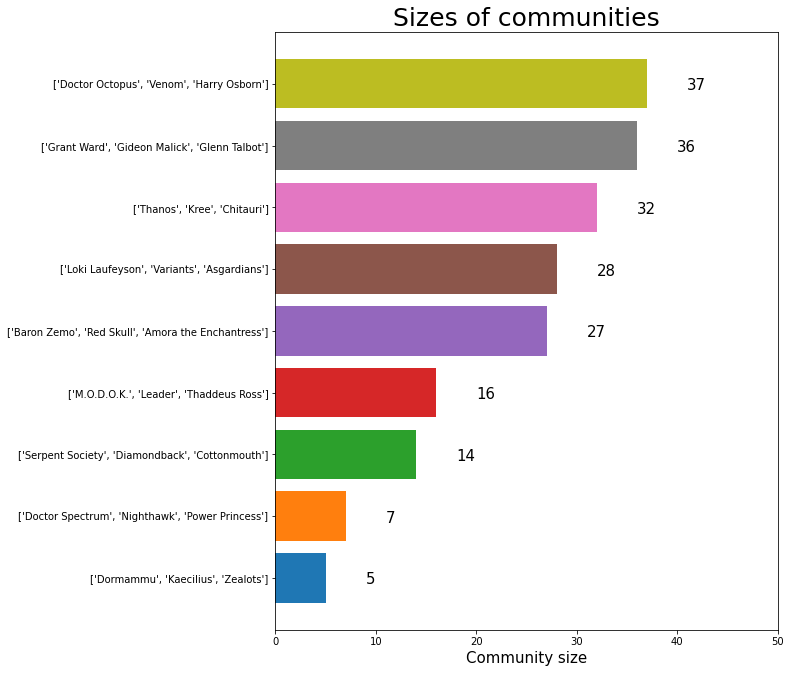

In [51]:
plt.figure(figsize=(9,11))
for value, names in sorted_top_communities:
    plt.barh(str(names), value)
    
for n,(value,index) in enumerate(sorted_top_communities):
    plt.text(value+4, n-0.1, str(value), fontsize=15)
    
plt.xlabel('Community size', fontsize = 15)
plt.title('Sizes of communities',fontsize=25)
plt.xlim(0,50);

The figure above shows the distribution of the communities.

### Discuss the outcome

Since this is a stochastic process, the communities will differ every time the algorithm is run, however we will be able to see specific patterns in relationships between charachters. For example, Scorpio and Dr. Octapus will always be in the same community with The Venom as they are the main antagonists of Spiderman. In the same manner, Red Skull will be with Bucky Barnes, while Loki will be with the Asgardians (as well as with Variations of Loki that are considered different characters).

## 3.2 Network visualization with Gephi <a class="anchor" id="section_3_2"></a>

### What we're interested in

We are interested in visualizing the network we have created and explore it further. We want to be able to examine the network in detail in order to perform exploratory analysis. This requires the ability to calculate relevant metrics for the network. 


In other words, we want to see clearly, the network from the following perspectives:

* Depending on the number of connections
* Depending on different communities
* Depending on betweeness centrality


Moreover, we would like to have an interactive figure to upload on our website.

### Explain the tool

The tool we used for the visulazation is called [Ref: Gephi](https://gephi.org/). Gephi is a network visualization and exploration tool that may be used with any type of network. This means that the tool can be used to explore a network and compute various properties. 

We imported our dataset into Gephi. Then we used the Circle Pack and ForceAtlas2 layouts to spatalize our undirected graph.

* Circle Pack: This layout allows us to group nodes according to their attributes and displays the nodes in a circle.

* ForceAtlas2: It's used to spatialize a weighted undirected graph in 2D. It is a force-directed layout, where edges attract their nodes, while nodes repel each other. 

### Apply the tool

#### Helper functions for visualization with gephi

* `dataframe_to_csv`: Loads the nodes and the egdes into csv file, in order to upload it to Gephi.

In [52]:
def dataframe_to_csv(marvel_df):
    marvel_df.to_csv('nodes.csv')

    marvel_links = get_hyperlinks(marvel_df)
    with open('egdes.csv','w') as out:
        csv_out=csv.writer(out)
    csv_out.writerow(['Source','Target'])
    for row in marvel_links:
        csv_out.writerow(row)

#### Visulazation ranked after degree

We ranked the nodes based on their degree, so bigger nodes have a higher degree, and vice versa. Then we colored the egdes and changed the layout until we were satisfied with the visulazation. This is displayed in the figure below.

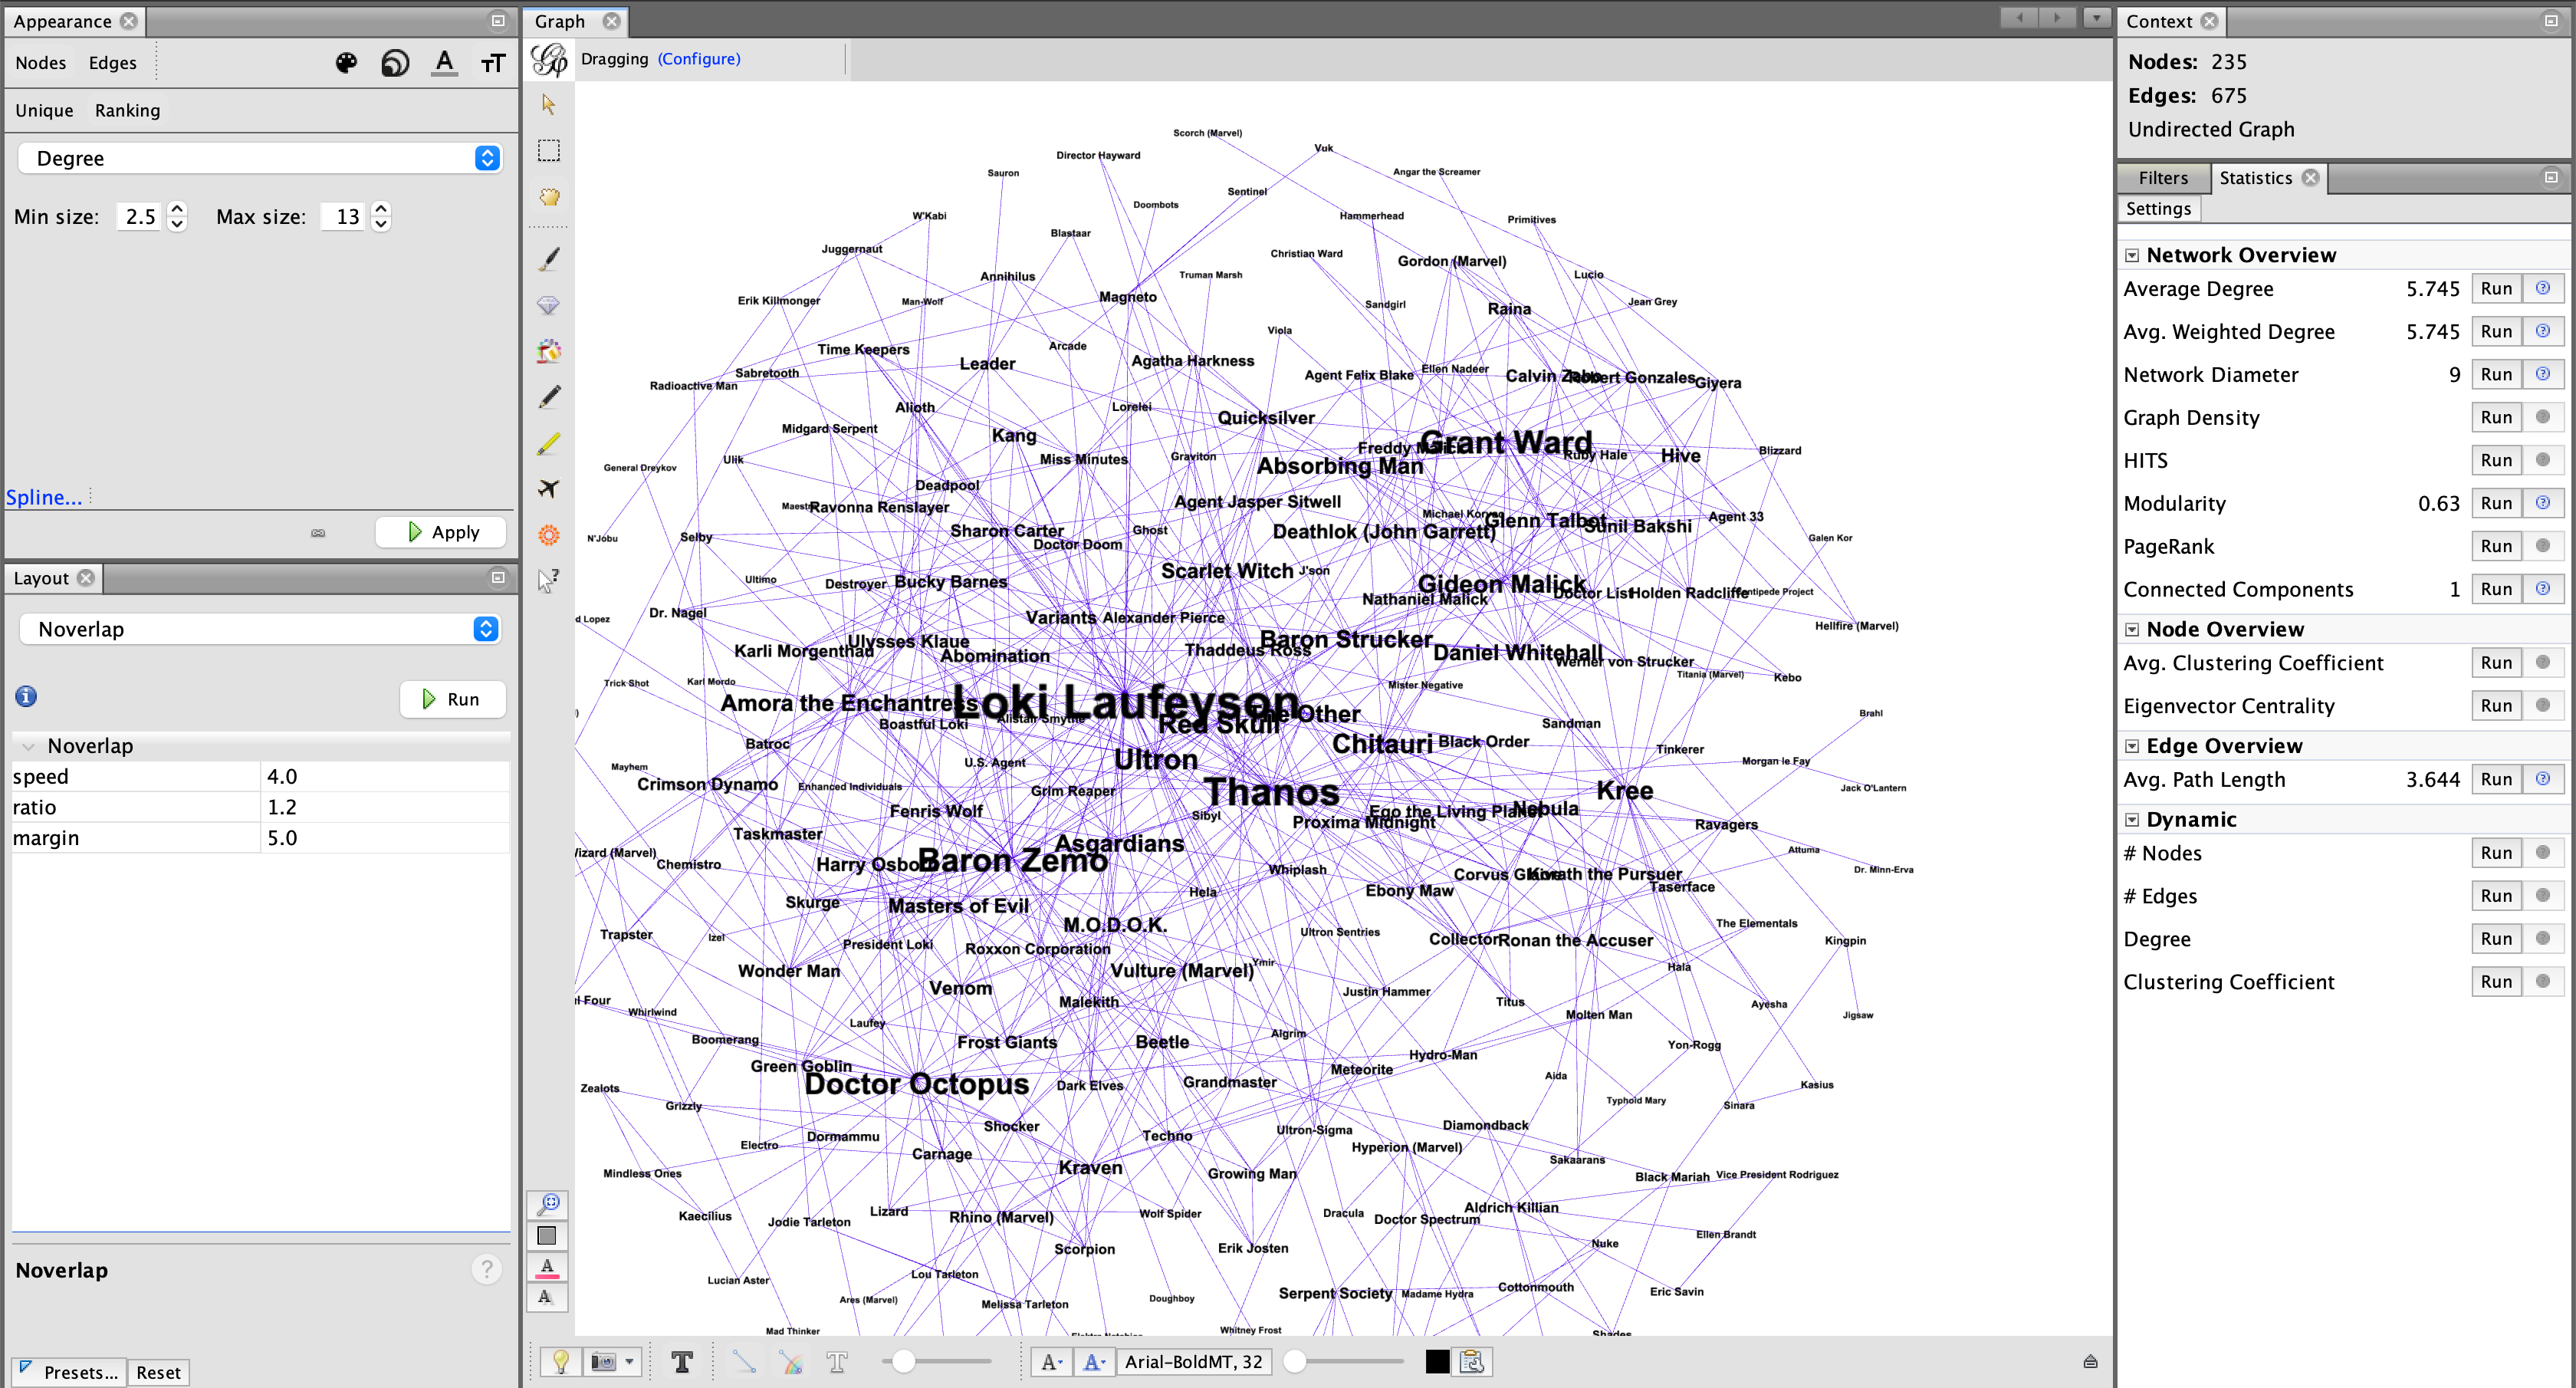

#### Visulazation with all communities

Furthermore, we used the previous mentioned csv file, that contained communities for each node in the network. Then we
colored the nodes based on their communities. The colors corresponding to each community can be seen in the left upper corner of the figure below.

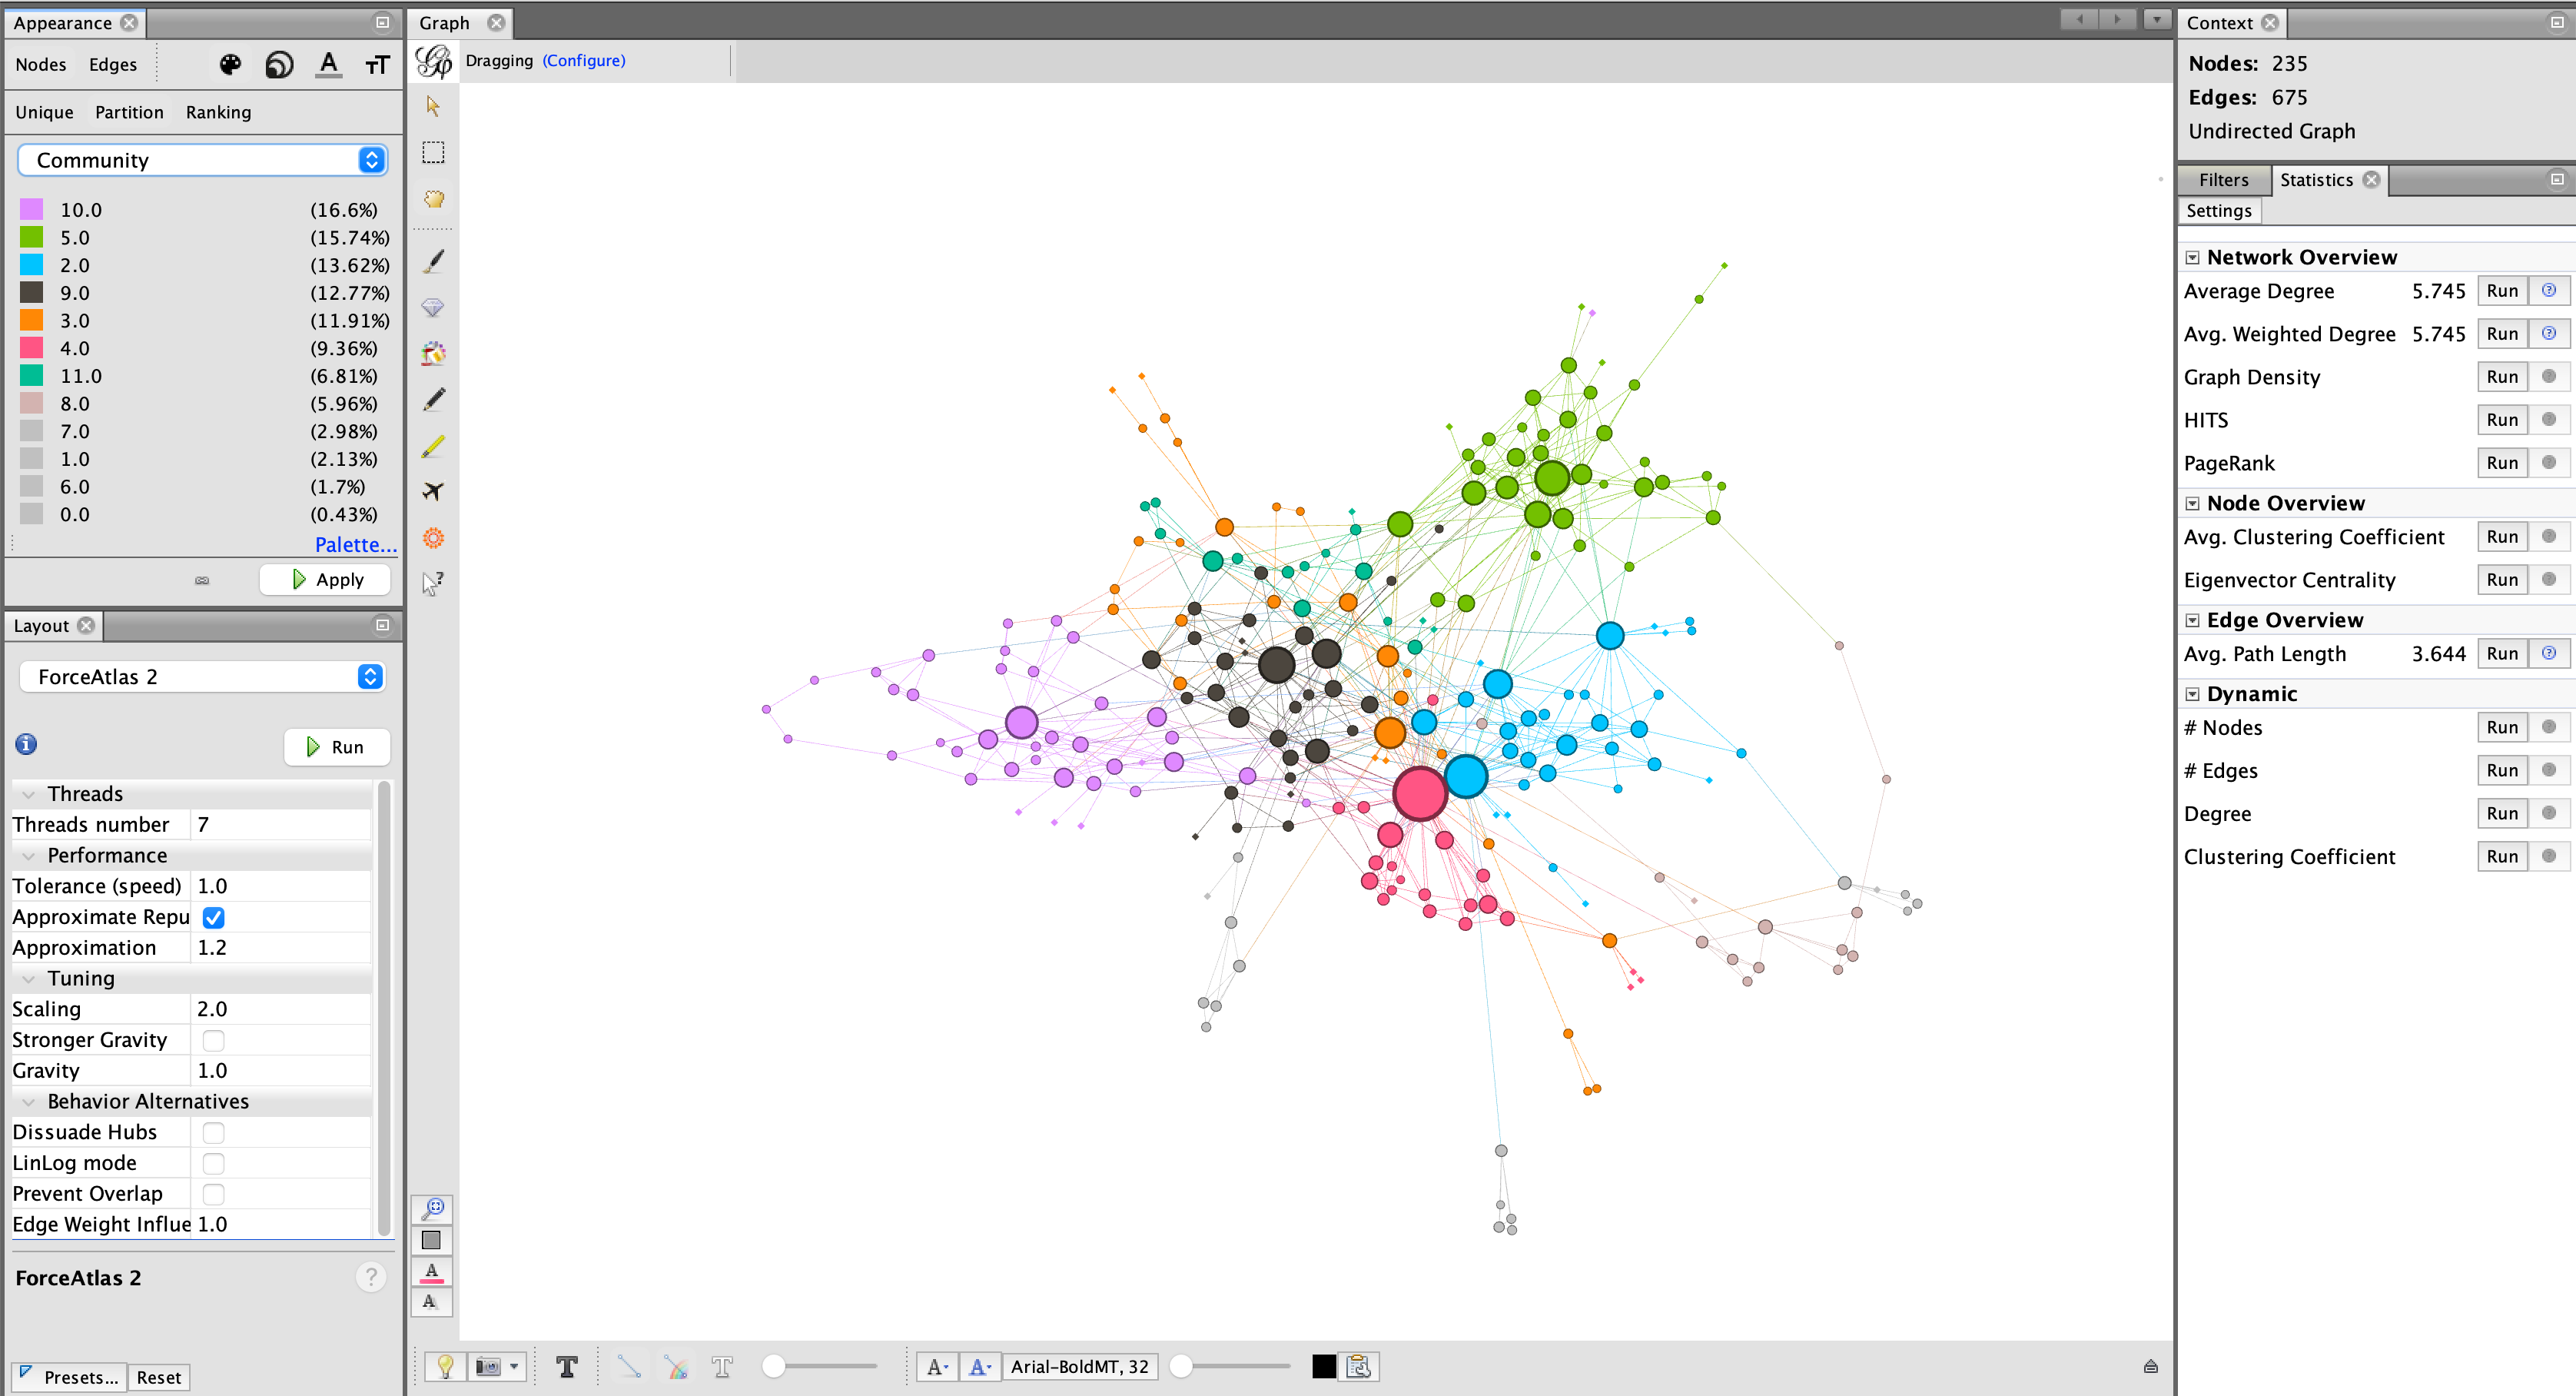

#### Visualazition ranked after betweeness centrality

Finally, we computed the betweenness centrality using the network diameter statistics that can be seen on the left of the figure below. Then the node size was changes according to the betweenness cantrality, so that the largest node had the highes betweenness centrality, and vice versa.

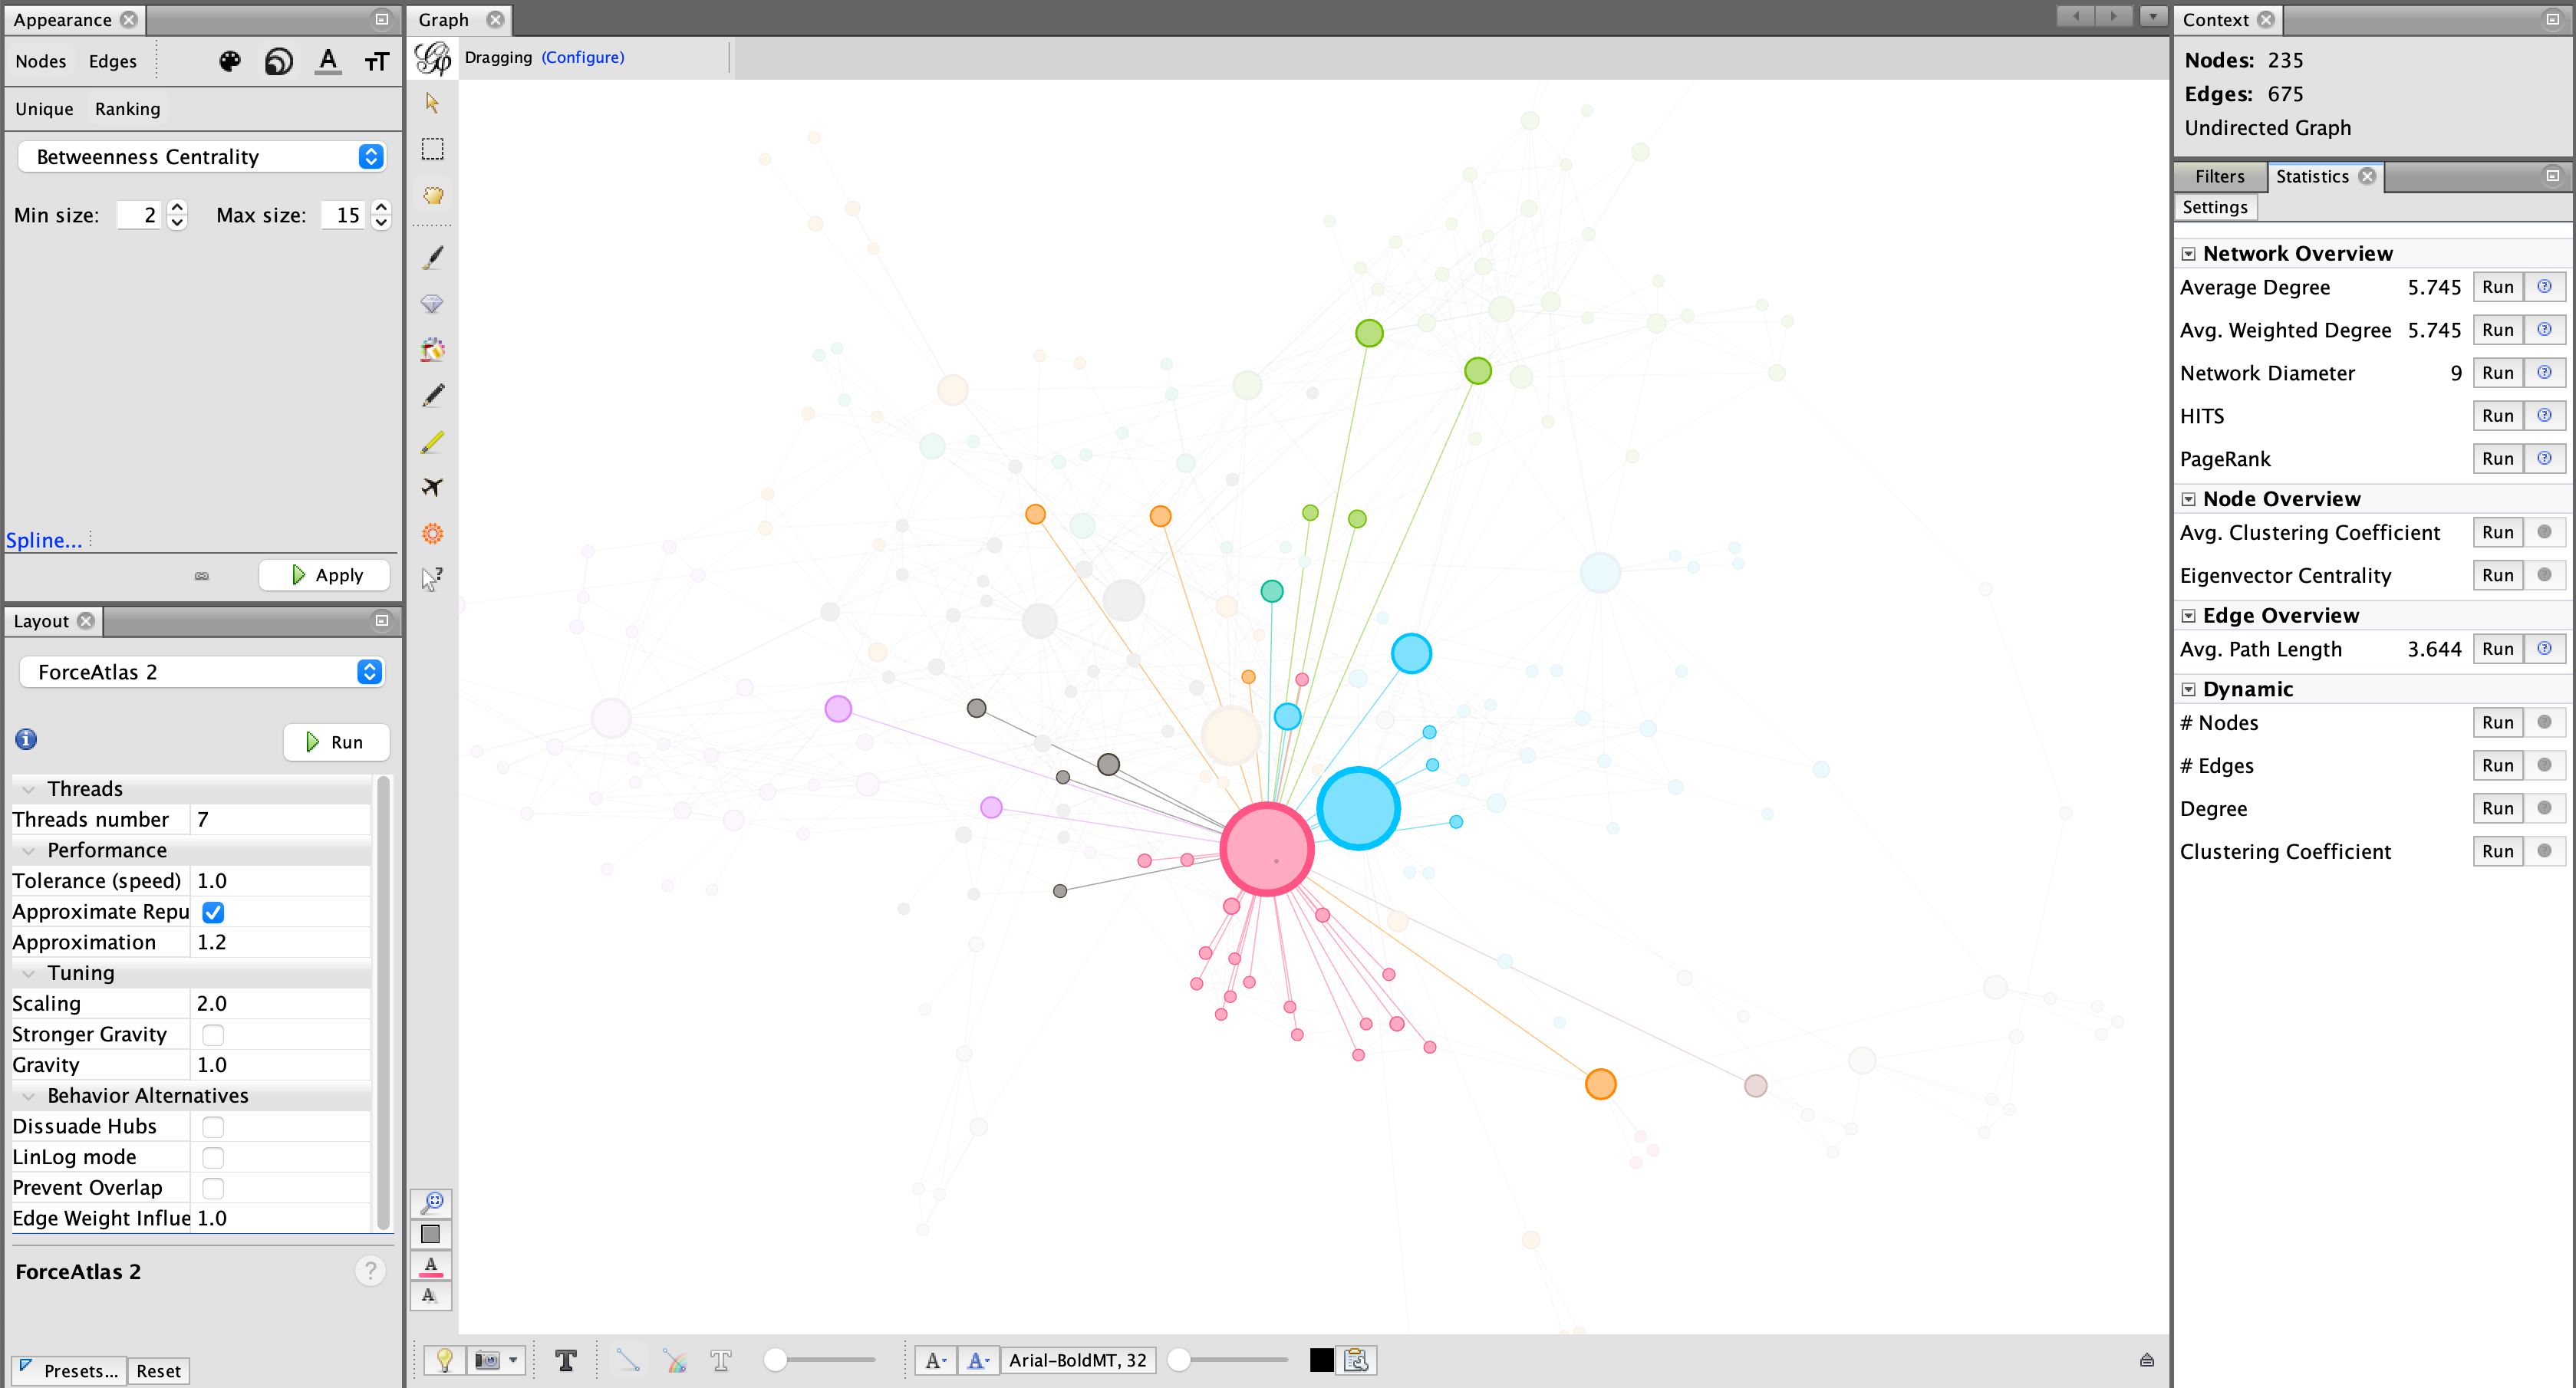

### Discuss the outcome

We were really satisfied with the results. We thought the tool visualized the network very well, and gave us a better intuition into the Marvel villains. 

We thought the graph that was ranked by degrees was very interesting. It explains the network well, and we can see clearly what characters are the most connected. With this we can get acquainted with the Marvel villains network.

When using Gephi, we found out that the node with the highest betweenness centrality was Loki Laufeyjarson. Betweenness centrality measures the number of times a node appears on the shortest path between nodes. As a result, nodes with high betweenness play an important role in linking the entire network. Since they dominate the shortest paths bettween nodes, they may cause disruption in egdes between nodes if they are not present in the network. 

When the node size is adjusted according to the betweenness centrality, it can be determined which characters are the most essential in terms of connecting all of the network's villains. The network's largest nodes have the highest betweenness centrality, and hence operate as bridges between two areas of the network or as shortcuts between parts that are farther away.

Loki Laufeyjarson, as previously said, has the highest network betweenness centrality. This could indicate that Loki Laufeyjarson is connected to villains from several other communities.

## 3.3 Sentiment analysis <a class="anchor" id="section_3_3"></a>

### What we're interested in

We're interested in seeing how emotions are shown in every charachters text file and try to detect which character  convey more positive or negative emotions. Two separate features are used to explore the sentiment of the text content, LabMT wordlist and the sentiment analysis tool VADER.

We also want visualize the average happiness scores for the Marvel network, and in addition we want to see the differene between characters with high and low happiness score. 

### Explain the tool

**LabMT wordlist**: The tokenized words are classified using the LabMT wordlist. The list includes frequent words as well as their average happiness score, which can be used to provide a score to each character. 
All character text files are tokenized(cleaned) and the average happiness score is generated using the words contained in the LabMT wordlist [Ref: Temporal Patterns of Happiness](https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0026752).

**VADER**: VADER is used to further analyze the description content of the happiest and saddest character. To familiarize ourselves with the traits that make a character happy or sad, we'd like to know the proportion of negative and positive phrases within each character file.

VADER is an NLTK sentiment analysis tool. The model is a lexicon and rule-based sentiment analysis tool which is sensitive to polarity, i.e., positive/negative, and the intensity of emotion. Within each character file, the proportion of positive, negative, and neutral words is found, i.e., the sum of the positive, negative, and neutral scores is equal to 1 for character. The one used in this part is the compound score, which is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive)[Ref: VADER](https://github.com/cjhutto/vaderSentiment#code-examples).

Positive emotions are expressed through words like "love" and "happy." It can also identify basic contexts, such as "not happy" being classified as a negative phrase.

### Apply the tool

#### Helper function for the sentimental analysis

* `get_dataframe_with_description`: Return a dataframe with the description for the items we send in.
* `show_wordcloud`: A function that generates a wordcloud.

In [53]:
def get_dataframe_with_description(dict_of_items, list_of_items, col):
    #create dataframe from dictionary to use for the wordcloud
    dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in dict_of_items.items() })
    dict_df = dict_df.T

    # merge all columns with strings to one column with all the strings
    df_w = pd.Series(dict_df.fillna('').values.tolist()).str.join(' ')
    df_w = df_w.to_frame()

    df_w[col] = list_of_items
    df_w = df_w.rename(columns={0: 'description'})
    return df_w

In [54]:
def show_wordcloud(df_w, title, pic):
    text = ' '.join(df_w['description'].astype(str).tolist()) 
    #crete list of strings
    stopwords = set(wordcloud.STOPWORDS) #set stopwords, taken from library
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, colormap=sns.color_palette("hls", 8, as_cmap=True),
        max_font_size=100, max_words=200, mask=pic, background_color="white", contour_width=1, contour_color='black').generate(text)
    
    #nr of words included, size of biggest word etc..
    plt.figure(figsize=(8, 8), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear") 
    plt.axis('off')
    plt.title(title, fontsize=15)

We start by using tha SentimentIntensityAnalyzer, wich takes in a string and returns a dictonary with 4 scores for every character. The four scores are, negative, neutral, positive and compound. Compound is computed by normalizing the three former mentioned scores. Then we compute the average compound score (happiness score), for the top 3 most connected characters in every comunity in our network. 

In [55]:
# make a list of all the charcters from Marvel
list_of_marvel_ch = list(marvel_df['name_of_villains'])
# get a cleaned text with the Marvel characters
dict_of_chars = get_cleaned_dict(marvel_df, 'name_of_villains', list_of_marvel_ch)

In [56]:
# get the top 3 most connected villain in each community
community_names = [", ".join(sorted([node for node in com], 
                                    key=lambda x: gcc_marvel.degree(x), 
                                    reverse=True)[:3]) for com in marvel_communities]

In [57]:
analyzer = SentimentIntensityAnalyzer()

# The sentiment for each character is given as follows
vader_sentiment_values = {}
for name, val in dict_of_chars.items():
    vader_sentiment_values[name] = analyzer.polarity_scores(' '.join(val)) # vader takes whole strings, not tokens

In [58]:
# Use only the compound values for evaluation
vader_compound_sentiment_values = {}
for name, val in vader_sentiment_values.items():
    vader_compound_sentiment_values[name] = vader_sentiment_values[name]['compound']

In [59]:
# calculate the average of the average sentiment values
vader_community_average = {}

for i, com in enumerate(marvel_communities):
        vader_community_average[community_names[i]] = np.mean([vader_compound_sentiment_values.get(node, 0.0) 
                                                               for node in com])

The figure below show the average compound scores for every community in our network. We notice that the community that contains Loki Laufeyson, Variants and Asgardians always tend to have one of the lowest average compound score, this is not a surprice since Loki Laufeyson is the biggest villain in the Marvel villain network.

In [60]:
vader_sorted_com = sorted([(com, value) for com, value in vader_community_average.items()], key=lambda x: x[1])

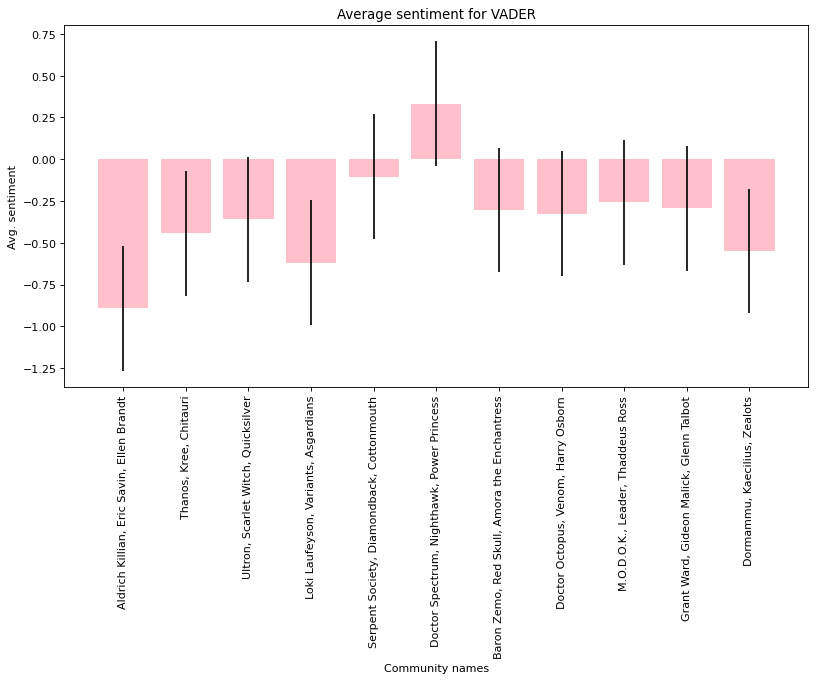

In [61]:
# Figure creation
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
 
# creating the bar plot
yerror2 = sem([vader_compound_sentiment_values.get(node, 0.0) for node in com])
plt.bar(list(vader_community_average.keys()), list(vader_community_average.values()), yerr = yerror2, color ='pink')

plt.xticks(list(vader_community_average.keys()), rotation='vertical') 
plt.xlabel("Community names")
plt.ylabel("Avg. sentiment")
plt.title("Average sentiment for VADER");

Next we computed the happiness score for every villain in our Marvel network. Below are displayed both the top 10 villains with the haighest happiness score and the top 10 villains with the lowest happiness score.

In [62]:
# make a dataframe
vader_sentiment_df = pd.DataFrame({key:pd.Series(value) for key, value in vader_compound_sentiment_values.items()}).T
# sort values by the happiness score
vader_sentiment_df = vader_sentiment_df.sort_values(by=[0])
# change the name of the column
vader_sentiment_df['happiness_score'] = vader_sentiment_df[0]
del vader_sentiment_df[0]

In [63]:
# get the top 10 happiest characters
print('Top 10 villains with the highest happiness score:')
vader_sentiment_df.tail(10)


Top 10 villains with the highest happiness score:


happiness_score
Nightmare               0.9716
M.O.D.O.K.              0.9744
Cecilia Reyes           0.9815
Abomination             0.9832
Quicksilver             0.9846
Trish Walker            0.9880
Erik Josten             0.9919
U.S. Agent              0.9924
Grandmaster             0.9943
Lizard                  0.9955

In [64]:
# get the top 10 saddest characters
print('Top 10 villains with the lowest happiness score:')
vader_sentiment_df.head(10) 

Top 10 villains with the lowest happiness score:


happiness_score
Loki Laufeyson             -0.9999
Thanos                     -0.9998
Kang                       -0.9997
Masters of Evil            -0.9994
Variants                   -0.9993
Malekith                   -0.9993
Ronan the Accuser          -0.9992
Karli Morgenthau           -0.9992
Bucky Barnes               -0.9991
Baron Zemo                 -0.9991

Then we found the average happiness score depending on the importance of a villain, in other words, if a character is a min antagonist or a lessar villain. We noticed that there is some difference in the scores, and the main antagonist tend to have a lower happiness score than the lesser villain. This seems accurate since the main antagonists are of course the baddest villains.

We also computed the average happiness score depending on the status of a character, meaning if the character is dead or alive. There however we did not see significant difference in the happiness score.

In [65]:
vader_sentiment_df = vader_sentiment_df.reset_index()
vader_sentiment_df['name_of_villains'] = vader_sentiment_df['index']
del vader_sentiment_df['index']

In [66]:
# marge the marvel_df with the vader_sentiment_df to get the happiness score as well as every other column in our new dataframe
marvel_df_happiness_score = pd.merge(marvel_df, vader_sentiment_df, on='name_of_villains', how='inner')
# find the average happiness score for main antagonists and lesser villains
antagonist_avg = marvel_df_happiness_score.groupby('Importance').mean()
# find the average happiness score for alive and deceased villains
deceased_avg = marvel_df_happiness_score.groupby('Status').mean()

In [67]:
antagonist_avg

happiness_score
Importance                       
Lesser villain          -0.259876
Main antagonists        -0.583203

In [68]:
deceased_avg

happiness_score
Status                   
Alive           -0.249746
Deceased        -0.415851

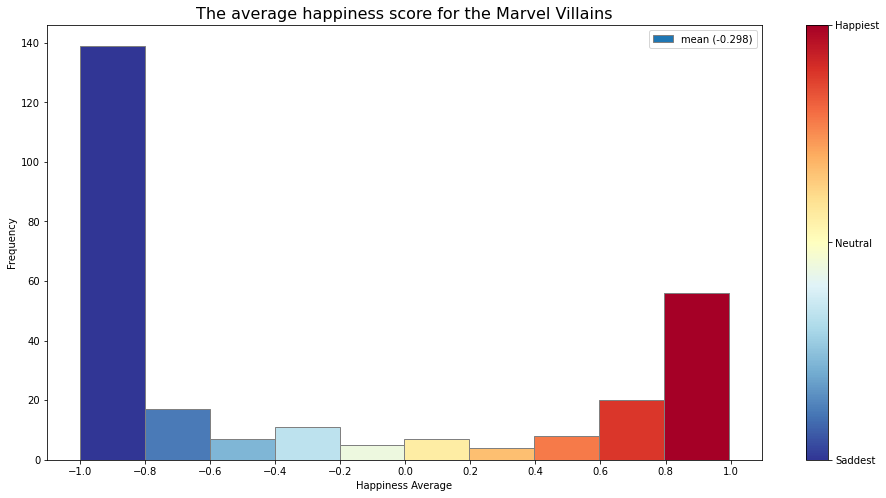

In [69]:
# use a colormap to color the bins
color_map = plt.cm.get_cmap('RdYlBu_r')

# find the mean and median
mean = vader_sentiment_df.happiness_score.mean()

fig = plt.figure(figsize = (16,8))
ax = fig.gca()

# plot histogram
n, bins, patches = plt.hist(vader_sentiment_df.happiness_score, bins="auto", edgecolor="grey")
bin_centers = 0.5 * (bins[:-1] + bins[1:])

plt.legend([f'mean ({np.round(mean,3)})'])
plt.ylabel('Frequency')
plt.xlabel('Happiness Average')
plt.title('The average happiness score for the Marvel Villains',fontsize=16)
plt.xticks(np.arange(min(vader_sentiment_df['happiness_score']), max(vader_sentiment_df['happiness_score'])+0.2, 0.2))
plt.grid(False)

# normalize colors
color = bin_centers - min(bin_centers)
color /= max(color)

for c, p in zip(color, patches):
    plt.setp(p, 'facecolor', color_map(c))

# normalize colors
color = bin_centers - min(bin_centers)
color /= max(color)

for c, p in zip(color, patches):
    plt.setp(p, 'facecolor', color_map(c))

# create colorbar
sm = plt.cm.ScalarMappable(cmap=color_map)
sm._A = []
cb = plt.colorbar(sm)
cb.set_ticks([0.0, 0.5, 1.0])
cb.set_ticklabels(["Saddest", "Neutral", "Happiest"])

From the figure above we see that the happiness score tends to be low. The mean value for the happiness score is -0.194 which is rather low and is in line with our network, since we are examining the Marvel Villains and they are most often not described in a kind way.

Next we looked at the average happiness score for the main anatagonists of our network. The results can be seen below.

In [198]:
df_importance_sentiment = pd.merge(vader_sentiment_df, marvel_df, on='name_of_villains', how='inner')
df_importance_sentiment_main = df_importance_sentiment.loc[df_importance_sentiment['Importance'] ==
                                                           'Main antagonists'] 

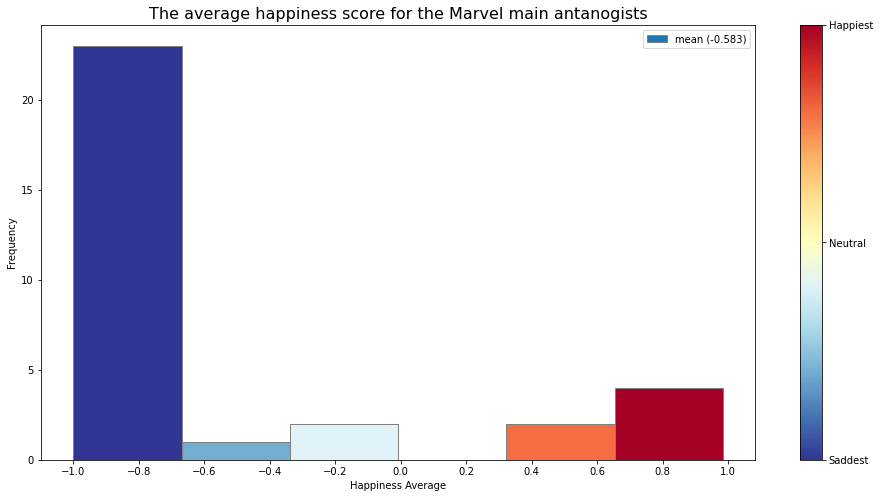

In [200]:
# use a colormap to color the bins
color_map = plt.cm.get_cmap('RdYlBu_r')

# find the mean and median
mean = df_importance_sentiment_main.happiness_score.mean()

fig = plt.figure(figsize = (16,8))
ax = fig.gca()

# plot histogram
n, bins, patches = plt.hist(df_importance_sentiment_main.happiness_score, bins="auto", edgecolor="grey")
bin_centers = 0.5 * (bins[:-1] + bins[1:])

plt.legend([f'mean ({np.round(mean,3)})'])
plt.ylabel('Frequency')
plt.xlabel('Happiness Average')
plt.title('The average happiness score for the Marvel main antanogists',fontsize=16)
plt.xticks(np.arange(min(df_importance_sentiment_main['happiness_score']), max(df_importance_sentiment_main['happiness_score'])+0.2, 0.2))
plt.grid(False)

# normalize colors
color = bin_centers - min(bin_centers)
color /= max(color)

for c, p in zip(color, patches):
    plt.setp(p, 'facecolor', color_map(c))

# normalize colors
color = bin_centers - min(bin_centers)
color /= max(color)

for c, p in zip(color, patches):
    plt.setp(p, 'facecolor', color_map(c))

# create colorbar
sm = plt.cm.ScalarMappable(cmap=color_map)
sm._A = []
cb = plt.colorbar(sm)
cb.set_ticks([0.0, 0.5, 1.0])
cb.set_ticklabels(["Saddest", "Neutral", "Happiest"])

From this we can conclude that the main antagonists are in fact much sadder then the others. By only looking at the main antagonists, the average happniess score droppes from -0.298 to -0.583.

In [70]:
# charcters with a very low happiness score
negative_happiness = marvel_df_happiness_score.sort_values('happiness_score')[:5]
# characters with a very high happiness score
positive_happiness = marvel_df_happiness_score.sort_values('happiness_score')[269:]

In [71]:
# dataframe with the description of each villain
char_description_df = get_dataframe_with_description(dict_of_chars, list_of_marvel_ch, 'name_of_villains')

In [72]:
# merge positive happiness datafrrame with the description dataframe
positive_villains = pd.merge(positive_happiness, char_description_df, on='name_of_villains', how='left')
positive_villains = positive_villains[['description', 'name_of_villains']]

# merge negative happiness datafrrame with the description dataframe
negative_villains = pd.merge(negative_happiness, char_description_df, on='name_of_villains', how='left')
negative_villains = negative_villains[['description', 'name_of_villains']]

In [73]:
happy_mask = np.array(Image.open('happy.jpg'))
sad_mask = np.array(Image.open('sad.jpg'))

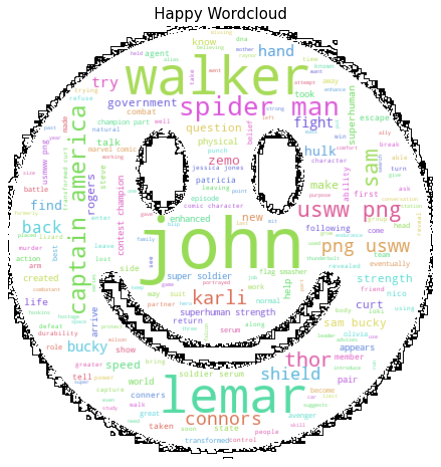

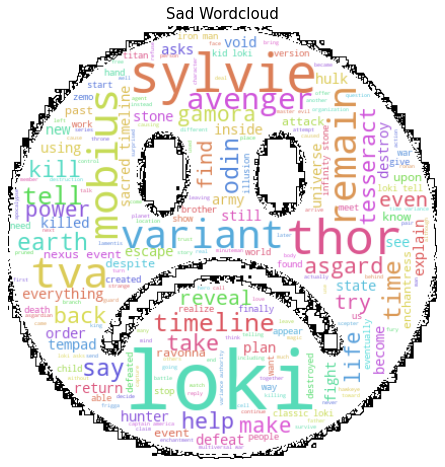

In [74]:
# happy wordcloud
show_wordcloud(positive_villains, "Happy Wordcloud", happy_mask)
# sad wordcloud
show_wordcloud(negative_villains, "Sad Wordcloud", sad_mask)

Wordclouds were made for the happies and the saddes villains, to get a better understanding of the data. We can see that the wordclouds tell a story. The happy wordcloud contains words and names. The names that appear large in the happy wordcloud are e.g Spider Man, Nathaniel and John. These are all defined as good characters in the Marvel universe. In the happy wordcloud there also appear words like, find, power, shield and life, who are all positive words.

However, in the sad wordcloud, there are names like Loki, Sylvie and Mobius who are defined as bad characters in the Marvel universe. We also see words like kill, destroy, help, fight and take which are words that we can agree decribe sad situations.

### Discuss the outcome

When applaying the tool, we saw that the majority of the characters in our dataset have a low happiness score, and therefore the average happiness score is quite low. Again, this makes sense as all the charcters in our dataset are villains from the Marvel Universe.  


By using the average happiness score for common words in the LabMT wordlist we were able to categorize characters according to their average happiness score. Apparent patterns were discovered. Happinesses score for characters is lower if words like destroy, kill, fight and take appear often in their description. The same we can counclude about the happier characters, when words like, power, shield and life seem to appear more often.

## 3.4 TF-IDF <a class="anchor" id="section_3_4"></a>

### What we're interested in

We want to transform our tokenized data into numerical data that we can work with.

### Explain the tool

Term frequency or TF defines how frequent a term appears in the Wiki-page. This however is not good enough since many terms are repeated across the communities Wiki-page, implying that they are not specific for them. Anoter term, IDF, or the inverse document frequency, is presented to identify specific terms for the communities. This term is based in the frquency of the same term in other communities, and if the word is frequent elsewhere, it lowers the score.

So the formula for our TF-IDF values is:

${\displaystyle f_{t,d}\cdot \log {\frac {N}{n_{t}}}}$

where $f_{t,d}$ is the term frequency (t) in the document (d). N is the total number of documents and $n_t$ is document frequency. [ref: TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

### Apply the tool

#### Helper functions for TF-IDF

* `get_community_list`: Return a list of all the communities as well as a list of all the nodes/villains in our network.
* `get_top_5_communities`: Find the top 5 communities in our network.
* `get_clean_word_list`: Returns a dictionary with clean word list for every community.
* `get_unique_word_list`: Returns a list of all unique words from our dataset.
* `count_community`: Returns a dictionary with the count (how many times the word appears in the text) for all the words in each community.
* `calculate_TF`: Calculates the TF for each word.
* `get_TF_list`: Returns a list with all the calculated TF.
* `get_dict_with_TF`: Returns a dictionary for each word with the corresponding TF.
* `get_IDF_list`: Returns a list with a count for the number of documents a word appears in.
* `calculate_TFIDF`: Caluculated the TF-IDF for every word in every top five communities
* `get_corresponding_word_for_IDF`: Returns a dictionary with the TF-IDF and the corresponding word.

In [75]:
def get_commuunity_list(partition, graph):
    community_list = []
    list_nodes = []
    for community in set(partition.values()):
        for node in partition.keys():
            if partition[node] == community:
                list_nodes.append(node)
    
        for i in list_nodes:
            community_graph = nx.subgraph(gcc_undirected_marvel, i)
    
        community_list.append(community_graph)
    return community_list, list_nodes

In [76]:
def get_top_5_communities(partition_counts, community_list):
    # Find the top 5 communities
    top_5_communities = []
    for i in partition_counts.index[:5]:
        top_5_communities.append(community_list[i])
    return top_5_communities

In [77]:
# Clean the text and return a dictionary with all the words in each community
def get_clean_word_list(list_nodes, partition):
    path = get_path('Clean_text/')
        
    dict_of_community = {}
    for c in partition:
        final_list = []
        for node in c.nodes.keys():
            content = read_data(path, node)

            pattern = r'\=+[\w\s]+\=+'
            new_line_pattern = r'\\n'
            new_content = re.sub(pattern, '', content)
            new_content = re.sub(new_line_pattern, ' ', content)
                
            comp_name, normal_name = get_composite_names(characters_df)
            
            for name in comp_name:
                new_content = new_content.replace(name, "")
        
            tk = RegexpTokenizer(r'\w+') # nota þennan tokenizer til þess að geta removeað punktuation á auðveldan hátt
            token_content = tk.tokenize(content)
    
            # hér remove-a normal names
            words = [word for word in token_content if word not in normal_name]
    
            # setja allt i lower case
            words = [word.lower() for word in words]

            # remove-a stop words
            words = [word for word in words if word not in stopwords.words('english')]

            # remove tokens containing numbers
            words = [x for x in words if not any(c.isdigit() for c in x)]

            wnl = WordNetLemmatizer()
            words = [wnl.lemmatize(word) for word in words]
        
            final_list.extend(words) 
        dict_of_community[node] = final_list
    return dict_of_community

In [78]:
def get_unique_word_list(dict_of_community):
    # Get a unique list of all the words in dict_of_community
    word_list = []
    for key, val in dict_of_community.items():
        word_list.extend(val)
    unique_word_list = list(set(word_list))
    return unique_word_list

In [79]:
# Count how many times every word appears in each comminty
def count_community(dict_of_community, unique_word_list):
    TF_dict = {} 
    for key, val in dict_of_community.items():
        word_count = []
        for word in unique_word_list:
            count = 0
            for i in val:
                if word == i:
                    count += 1
            word_count.append(count)
        TF_dict[key] = word_count
    return TF_dict

In [80]:
def calculate_TF(dict_of_community, TF_dict):
    # Calculate the TF for every word
    calculate_TF = {}
    for key, val in dict_of_community.items():
        for count in TF_dict[key]:
            if key in calculate_TF:
                calculate_TF[key].extend([count/sum(TF_dict[key])])
            else:
                calculate_TF[key] = [count/sum(TF_dict[key])]
    return calculate_TF

In [81]:
def get_TF_list(calculate_TF):
    # Make a list of five lists containg all the TFs for all the five communities 
    TF_list = []
    for key, val in calculate_TF.items():
        TF_list.append(val)
    return TF_list

In [82]:
def get_dict_with_TF(unique_word_list, TF_dict, TF_list):
    # List of five dictionaries (one for each comminty) with all the words and corresponing TF value
    list_of_TF_dict = []
    for j in range(5):
        TF_dict = {}
        for i, word in enumerate(unique_word_list):
            TF_dict[word] = TF_list[j][i]
        list_of_TF_dict.append(TF_dict)
    return list_of_TF_dict

In [83]:
def get_IDF_list(unique_word_list, dict_of_community_IDF):
    IDF_list = []
    for word in unique_word_list:
        count = 0
        for key, val in dict_of_community_IDF.items():
            if word in val:
                count += 1
        IDF_list.append(count)
    return IDF_list

In [84]:
def calculate_TFIDF(IDF_list, list_of_TF_dict, community_list):
    IDF = []
    for number in IDF_list:
        for lists in list_of_TF_dict:
            for k, v in lists.items():
                IDF.append(v * (math.log(len(community_list)/(number+1))))
    return IDF

In [85]:
def get_corresponding_word_for_IDF(unique_word_list, IDF):
    calculate_IDF = {}
    for i, word in enumerate(unique_word_list):
        calculate_IDF[word] = IDF[i]
    return calculate_IDF

In [86]:
community_list, list_nodes = get_commuunity_list(partition, gcc_undirected_marvel)
partition_counts = pd.Series(list(partition.values())).value_counts()
top_5_communities = get_top_5_communities(partition_counts, community_list)
dict_of_community = get_clean_word_list(list_nodes, top_5_communities)

In [95]:
unique_word_list = get_unique_word_list(dict_of_community)

In [96]:
TF_dict = count_community(dict_of_community, unique_word_list)
calculate_TF = calculate_TF(dict_of_community, TF_dict)
TF_list = get_TF_list(calculate_TF)
list_of_TF_dict = get_dict_with_TF(unique_word_list, TF_dict, TF_list) 

In [97]:
print('There are', len(community_list), 'communities in total')

There are 11 communities in total


In [98]:
mod = community.modularity(partition, gcc_undirected_marvel)
print('The values of modularity is:', mod)

The values of modularity is: 0.6308521262002744


In [100]:
dict_of_community_IDF = get_clean_word_list(list_nodes, community_list)

In [101]:
IDF_list = get_IDF_list(unique_word_list, dict_of_community_IDF)
IDF = calculate_TFIDF(IDF_list, list_of_TF_dict, community_list)
calculate_IDF = get_corresponding_word_for_IDF(unique_word_list, IDF)

In [99]:
# Sorted dictionary with the top 5 words for each community
#list_of_names = ['Primitives', 'Enhanced Individuals', 'Attuma', 'N Jobu', 'Mayhem']
list_of_names = ['Community 1', 'Community 2', 'Community 3','Community 4','Community 5']
print("")
for i, words in enumerate(list_of_TF_dict):
    sorted_dict = {k: v for k, v in sorted(words.items(), key=lambda item: item[1])}
    print(list_of_names[i],':')
    for key, val in list(sorted_dict.items())[-5:]:
        print(key, val)
    print("")


Community 1 :
primitive 0.03225806451612903
agent 0.03225806451612903
radcliffe 0.03225806451612903
virus 0.04838709677419355
inhumans 0.06451612903225806

Community 2 :
inhumans 0.02830188679245283
power 0.03773584905660377
enhanced 0.04716981132075472
individual 0.04716981132075472
like 0.05660377358490566

Community 3 :
marvel 0.02030456852791878
avenger 0.02030456852791878
earth 0.02030456852791878
ronan 0.04060913705583756
loki 0.04568527918781726

Community 4 :
brigid 0.047619047619047616
marvel 0.047619047619047616
roxxon 0.047619047619047616
cloak 0.07142857142857142
dagger 0.07142857142857142

Community 5 :
appears 0.02127659574468085
hand 0.028368794326241134
combat 0.028368794326241134
superhuman 0.028368794326241134
strength 0.04964539007092199



Here are the top 5 words for the five largest communities according to the TF values, in an ascending order for every community. We can se that the word'Marvel' appears in three of the communities, which of course makes sense because the network is about the Marvel universe.

In [102]:
print('The 5 top words according to TF-IDF:')
print("")
sorted_dict_IDF = {k: v for k, v in sorted(calculate_IDF.items(), key=lambda item: item[1])}
for key, val in list(sorted_dict_IDF.items())[-5:]:
    print(key, val)
print("")

The 5 top words according to TF-IDF:

primitive 0.05499187394317501
agent 0.05499187394317501
radcliffe 0.05499187394317501
virus 0.08248781091476251
inhumans 0.10998374788635001



Here are listed the top 5 words from the TF-IDF calculations. The words are derived from all communities and are shown in an ascending order. Again the words in here, Marvel and power are a 

### Discuss the outcome

## 3.5 Word-clouds for all universes <a class="anchor" id="section_3_5"></a>

### What we're interested in

Word clouds are used to show the releative importance of words and are a visually appealing way to get a sense of the text. Now we want to go back and take a look at our original dataset, which includes all four universes from Disney, that is, Marvel, Walt Disney, Star Wars and Pixar. We are interesting in if there is some similarities that we might see between the universes.

### Explain the tool

We use a package in python called wordcloud, which takes in a dictionary where the keys are supposed the be individual words and the values their weight. 

For the images, we also specify things like a mask that we want the word cloud to fit into. These are icons for each of the universes, to be able to empahsize what we are working with each time.

### Apply the tool

Below are the wordcloud for the four universes displayed.

In [103]:
univ_description_df = get_dataframe_with_description(dict_of_universes, universe_list, 'universe')

In [104]:
star_wars_mask = np.array(Image.open('starwars.jpeg'))
marvel_mask = np.array(Image.open('marvel.jpeg'))
pixar_mask = np.array(Image.open('maggiv.jpeg'))
disney_mask = np.array(Image.open('disney.jpeg'))

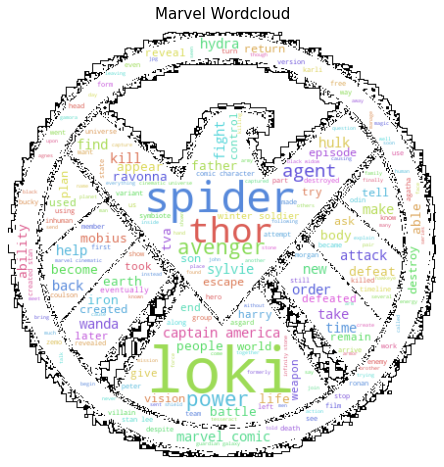

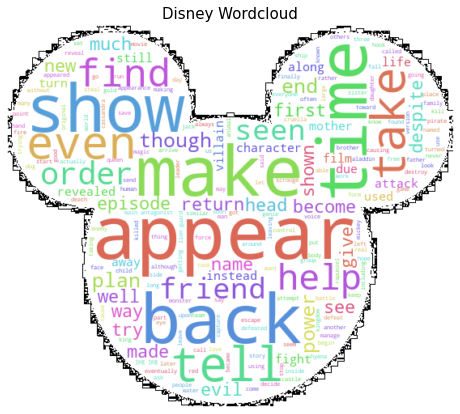

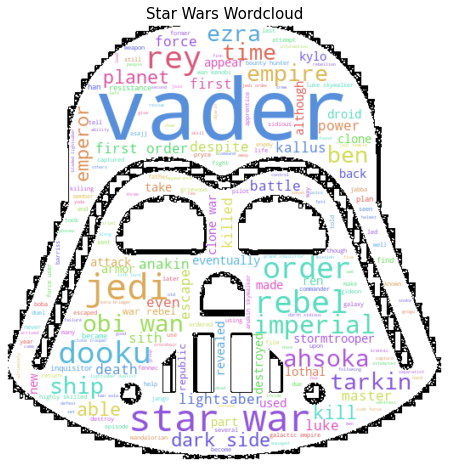

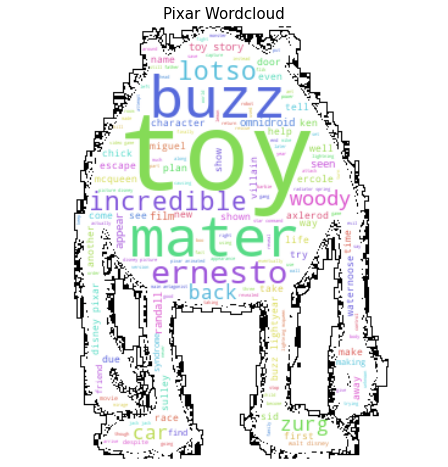

In [105]:
show_wordcloud(univ_description_df[univ_description_df.universe=='Marvel'], "Marvel Wordcloud", marvel_mask)
show_wordcloud(univ_description_df[univ_description_df.universe=='Disney'], "Disney Wordcloud", disney_mask)
show_wordcloud(univ_description_df[univ_description_df.universe=='Star Wars'], "Star Wars Wordcloud", star_wars_mask)
show_wordcloud(univ_description_df[univ_description_df.universe=='Pixar'], "Pixar Wordcloud", pixar_mask)

### Discuss the outcome

We were extreamly happy with the word clouds, we thought they told a good story about the different universise. 
If we take a further look into the Marvel - wordcloud we see words like Spiderman, Loki, Marvel comics, kill, return, Hulk and Thor, these words are great example of what the Marvel universe is all about. 

The same can be said about the other universe wordclouds, for example, in the Disney wordcloud we see words such as tell, time, show and appear, these are all words that fit well when telling a story like Walt disney does. In the Star Wars wordcloud, we see words like Vader which is a famous character in the Star Wars movie. Finally, in the Pixar wordcloud we see words such as Buzz, toy, Mater, incredible and Woody.

# 4. Discussion <a class="anchor" id="chapter4"></a>

**What went well?**

*Rre-processing the data:* For the most part, the data extraction proceeded smoothly. The data was extracted using the Fandom Wiki page, and former course experience assisted with extraxting the data, since code cells from previous assignments only needed to be adjusted to be used in this project. The data was really nice for scraping and we were able to process them quite reasonably such that we got a very nice results from most analysis attempts we did. 

*Network analysis:* The size of the network turned out to be much larger than we thought in the beginning. Extracting the Marvel subset from the whole disney network went really well and gave us opportunity to explore the Marvel universe further. The communities well matched our intuition of relationships. 

*Network visualization with Gephi:* We wanted to analyse our network much further and begun to serch on the internet how we could go about it. We ended upp finding the Gephi - program. At first we thought it would be a lot of trouble using the Gephi program, but it turned out to be a lot of fun using the gephi program, and we were quite pleased with how the network turned out. The analysis we did with Gephi provided us a better understanding of how the Marvel villain network is. 

*Sentiment analysis:* The sentiment analysis showed clear patterns within the Marvel universe. We were able to display the sentimental differences between characters descriptions and analyse. 

*TF-IDF:* Went really well, thanks to much of the pre-processing which ensured we had much less clutter.

*Word clouds:* All the wordclouds went fairly well in the project. They came out especially well, again thanks to the pre-processing.

*Website*: BÆTA VIÐ EHV SEM GEKK VEL MEÐ VEFSIÐUNA (VONANDI EHV A MORGUN)


**What is still missing and what could be improved?**

One of the main troubles in the beginning was to decide on the dataset we wanted to use. At first, we wanted to go with all the charcters from Disney and not only the villains, but there we had trouble with to much data and it being computationally too heavy. Then we went back, change something, and finally we ended up with the villains network.

Another thing we could have done better at the beginning was the cleaning of the text for each character. The code didn't manage to catch everything that we wanted to clean from the text. As a result, some wrong text slid into the community detection and therefore into the word clouds. Regardless of this, the communities and word clouds gave promising results.

What we would have liked to do is explore more characters in the whole Disney universe, rather than just taking the villains of disney. There we could have made a whole lot more of analysis on why the villains are the way they are. If the sample we selected had included a larger range of characters, we could have gotten greater insights and better results in the sentiment analysis section. 

We would have liked more information about each character so that our data could have had more depth. This would allow us to analyze the data much better, and we would then have the opportunity to use more tools within Python, such as KDE and others.

Making the website was hard and finding a way to display the figures on the website seemed impossible at some point during the process.

**Recipe for EVILNESS!!!**

Original recipe for 1 villain

Ingreedients:

* 3 2/3 cups - of being in the Marvel villain network.
* 1 tps - of high connections to other characters
* 1 cup - of being Alive
* 1 1/2 cups - of being Main antagonists
* 2 tps - of having words like kill, fight and destroy in your discription text

And, if all else fails, just be more like LOKI LAUFEYJARSON!

# 5. Reference <a class="anchor" id="chapter5"></a>

[1] Dodds, P. S. (2011, December 7). Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter. Journals.Plos. https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0026752


[2] Gephi - the open graph viz platform. [Online]. Available: https://gephi.org/

[3] Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

[4] Wikipedia contributors. (2021a, December 1). Modularity (networks). Wikipedia.             https://en.wikipedia.org/wiki/Modularity_(networks)

[5] Wikipedia contributors. (2021, December 1). Tf–idf. Wikipedia. https://en.wikipedia.org/wiki/Tf%E2%80%93idf

# 6. Contributions <a class="anchor" id="chapter6"></a>

**Shared responsibilities:** The majority of the implementation was done by more than one person. Most of the time one would start on a certain part and someone else would finish with it and then analyse. Discussion and interpretation of results was also shared among all of us in most parts.

**Angelo:** Responsible for community detection, sentiment analysis and TF-IDF. Shared responsibility in statistics about the data and analysing results.

**Aníta:** Responsible for finding the data and discussion part. Shared responsibility in cleaning, pre-processing, wordclouds, visualizing the data, statistics and analysing results.

**Gunnhildur:** Responsible for creating the website and converting notebook results to the website. Shared responsibility in cleaning, pre-processing, wordclouds, visualizing the data, statistics and analysing results.